In [ ]:
!kaggle datasets download -d sherylmehta/kodak-dataset
!unzip kodak-dataset.zip -d kodak-dataset

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import math


# Multi-Frequency Channel Attention
class MultiFrequencyChannelAttention(nn.Module):
    def __init__(self, channels, height, width, k=4):
        super(MultiFrequencyChannelAttention, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width
        self.k = k
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(),
            nn.Linear(channels // 4, channels)
        )
       
    def dct_2d(self, x, max_freq=3):
        b, c, h, w = x.shape
       
        # Create frequency basis for height dimension
        h_freq = torch.arange(h, device=x.device).float()
        h_basis = torch.arange(max_freq, device=x.device).float().unsqueeze(1)
        h_cos = torch.cos(math.pi * h_basis * (2 * h_freq + 1) / (2 * h))
       
        # Create frequency basis for width dimension
        w_freq = torch.arange(w, device=x.device).float()
        w_basis = torch.arange(max_freq, device=x.device).float().unsqueeze(1)
        w_cos = torch.cos(math.pi * w_basis * (2 * w_freq + 1) / (2 * w))
       
        # Compute DCT coefficients
        dct_h = torch.matmul(h_cos, x.reshape(b, c, h, w))
        dct_hw = torch.matmul(dct_h, w_cos.t())
       
        # Take average of coefficients
        dct_coeffs = torch.mean(torch.abs(dct_hw.reshape(b, c, -1)), dim=2)
       
        return dct_coeffs

    def forward(self, x):
        b, c, h, w = x.shape
       
        # If channels are not divisible by k, adjust k
        if c % self.k != 0:
            self.k = math.gcd(c, self.k)
       
        c_k = c // self.k
        freq_parts = []
       
        # Split channels into k parts and apply DCT
        for i in range(self.k):
            x_i = x[:, i*c_k:(i+1)*c_k, :, :]
            freq_i = self.dct_2d(x_i)
            freq_parts.append(freq_i)
       
        # Concatenate frequency components
        freq = torch.cat(freq_parts, dim=1)
       
        # Apply channel attention
        attention = torch.sigmoid(self.fc(freq))
       
        # Reshape and apply attention
        return x * attention.view(b, c, 1, 1)



# PMCN Module (rest of the classes remain the same as in your original code)
class PMCNModule(nn.Module):
    def __init__(self, in_channels, out_channels, height, width):
        super(PMCNModule, self).__init__()
        self.split_group = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=5, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=7, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=5, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=7, padding='same')
        ])
       
        self.left_branch = nn.ModuleList([
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same')
        ])
       
        self.right_branch = nn.ModuleList([
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same')
        ])
       
        self.combine = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.mfca = MultiFrequencyChannelAttention(out_channels, height, width, k=4)

    def forward(self, x):
        split_outputs = [conv(x) for conv in self.split_group]
       
        left_outputs = [left(split) for left, split in zip(self.left_branch, split_outputs[:4])]
        right_outputs = [right(split) for right, split in zip(self.right_branch, split_outputs[4:])]
       
        y_left = torch.cat(left_outputs, dim=1)
        y_right = torch.cat(right_outputs, dim=1)
       
        y = torch.cat([y_left, y_right], dim=1)
        y = self.combine(y)
        y = self.bn(y)
        y = self.relu(y)
        y = self.mfca(y)
       
        return y + x

# Importance Map
class ImportanceMap(nn.Module):
    def __init__(self, channels):
        super(ImportanceMap, self).__init__()
        self.conv = nn.Conv2d(channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.conv(x))



class CoreEncoder(nn.Module):
    def __init__(self, input_channels=3, base_channels=64):
        super(CoreEncoder, self).__init__()
        # Increased number of channels progressively
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )
       
        self.pmcn1 = PMCNModule(base_channels, base_channels, height=384, width=384)
        self.downsample1 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU()
        )
       
        self.pmcn2 = PMCNModule(base_channels*2, base_channels*2, height=192, width=192)
        self.downsample2 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU()
        )
       
        self.pmcn3 = PMCNModule(base_channels*4, base_channels*4, height=96, width=96)
        self.downsample3 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU()
        )
       
        self.importance_map = ImportanceMap(base_channels*8)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pmcn1(x1)
        x3 = self.downsample1(x2)
        x4 = self.pmcn2(x3)
        x5 = self.downsample2(x4)
        x6 = self.pmcn3(x5)
        encoded = self.downsample3(x6)
        importance = self.importance_map(encoded)
        return encoded, importance, (x2, x4, x6)  # Return intermediate features for skip connections

class CoreDecoder(nn.Module):
    def __init__(self, output_channels=3, base_channels=64):
        super(CoreDecoder, self).__init__()
        # Decoder with skip connections and progressive upsampling
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU()
        )
       
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4*2, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU()
        )
       
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2*2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )
       
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, output_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x, skip_features):
        x2, x4, x6 = skip_features
        x = self.upsample1(x)
        x = torch.cat([x, x6], dim=1)
        x = self.upsample2(x)
        x = torch.cat([x, x4], dim=1)
        x = self.upsample3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.final_conv(x)
        return x

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import numpy as np

class KodakDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
       
        if self.transform:
            image = self.transform(image)
       
        return image


# Quantization and Entropy Coding Components
class Quantizer(nn.Module):
    def __init__(self, num_centers=256):
        super(Quantizer, self).__init__()
        self.num_centers = num_centers
       
    def forward(self, x, training=True):
        if training:
            # Add uniform noise during training for better gradient approximation
            noise = torch.zeros_like(x).uniform_(-0.5/self.num_centers, 0.5/self.num_centers)
            x_noisy = x + noise
            return x_noisy
        else:
            # During inference, perform hard quantization
            x_quantized = torch.round(x * self.num_centers) / self.num_centers
            return x_quantized

class ArithmeticEncoder(nn.Module):
    def __init__(self):
        super(ArithmeticEncoder, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        return self.activation(self.conv(x))

class ArithmeticDecoder(nn.Module):
    def __init__(self):
        super(ArithmeticDecoder, self).__init__()
        self.conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
       
    def forward(self, x):
        return self.conv(x)

class PQF(nn.Module):
    def __init__(self, channels):
        super(PQF, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        residual = x
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        return x + residual

# Modified CompressionAutoencoder with Quantization and PQF
class CompressionAutoencoder(nn.Module):
    def __init__(self, input_channels=3, base_channels=64):
        super(CompressionAutoencoder, self).__init__()
        self.encoder = CoreEncoder(input_channels, base_channels)
        self.decoder = CoreDecoder(input_channels, base_channels)
        self.quantizer = Quantizer()
        self.arithmetic_encoder = ArithmeticEncoder()
        self.arithmetic_decoder = ArithmeticDecoder()
        self.pqf = PQF(base_channels * 8)  # Adjust channels based on encoded feature size
       
    def compress(self, x):
        # Encoding
        encoded, importance_map, skip_features = self.encoder(x)
       
        # Apply importance map
        weighted_encoded = encoded * importance_map
       
        # Quantization
        quantized = self.quantizer(weighted_encoded, training=self.training)
       
        # Arithmetic coding simulation
        compressed = self.arithmetic_encoder(importance_map)
       
        return quantized, compressed, importance_map, skip_features
   
    def decompress(self, quantized, compressed, skip_features):
        # Arithmetic decoding simulation
        decoded_importance = self.arithmetic_decoder(compressed)
       
        # Apply PQF enhancement
        enhanced = self.pqf(quantized)
       
        # Decode
        reconstructed = self.decoder(enhanced, skip_features)
       
        return reconstructed
   
    def forward(self, x):
        # Full forward pass
        quantized, compressed, importance_map, skip_features = self.compress(x)
        reconstructed = self.decompress(quantized, compressed, skip_features)
        return reconstructed, importance_map, quantized

# Modified loss function to include quantization and perceptual quality
def enhanced_loss_function(original, reconstructed, importance_map, encoded, quantized):
    # Reconstruction loss using L1 and SSIM
    l1_loss = nn.L1Loss()(reconstructed, original)
   
    # Perceptual loss component
    mse_loss = nn.MSELoss()(reconstructed, original)
   
    # Rate loss (sparsity constraint on the encoded representation)
    rate_loss = torch.mean(importance_map)
   
    # Quantization loss
    quant_loss = nn.MSELoss()(quantized, encoded.detach())
   
    # Combined loss with balanced weights
    total_loss = l1_loss + 0.1 * mse_loss + 0.5 * rate_loss + 0.1 * quant_loss
   
    return total_loss, l1_loss, rate_loss, quant_loss


def create_training_setup(learning_rate=0.002):    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CompressionAutoencoder().to(device)
   
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
   
    return model, enhanced_loss_function, optimizer, scheduler, device

# Modified training loop to handle new loss components
def train_model(model, train_loader, optimizer, scheduler, loss_function, device, num_epochs=40):
    model.train()
    history = {
        'total_loss': [],
        'reconstruction_loss': [],
        'rate_loss': [],
        'quantization_loss': []
    }
    best_loss = float('inf')
   
    for epoch in range(num_epochs):
        running_losses = {k: 0.0 for k in history.keys()}
       
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
           
            # Forward pass with compression and decompression
            reconstructed, importance_map, quantized = model(images)
           
            # Calculate losses
            total_loss, recon_loss, rate_loss, quant_loss = loss_function(
                images, reconstructed, importance_map, model.encoder(images)[0], quantized
            )
           
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
           
            # Update running losses
            running_losses['total_loss'] += total_loss.item()
            running_losses['reconstruction_loss'] += recon_loss.item()
            running_losses['rate_loss'] += rate_loss.item()
            running_losses['quantization_loss'] += quant_loss.item()
           
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Total Loss: {total_loss.item():.6f}')
       
        # Calculate and store average losses
        for k in history.keys():
            avg_loss = running_losses[k] / len(train_loader)
            history[k].append(avg_loss)
           
        scheduler.step(running_losses['total_loss'] / len(train_loader))
       
        # Save best model
        if history['total_loss'][-1] < best_loss:
            best_loss = history['total_loss'][-1]
            torch.save(model.state_dict(), 'best_model.pth')
       
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Average Total Loss: {history["total_loss"][-1]:.6f}, '
              f'Average Reconstruction Loss: {history["reconstruction_loss"][-1]:.6f}, '
              f'Average Rate Loss: {history["rate_loss"][-1]:.6f}, '
              f'Average Quantization Loss: {history["quantization_loss"][-1]:.6f}')
   
    return history

# Modified visualization function to include quantization effects
def visualize_results(model, train_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        images = next(iter(train_loader))[:num_images].to(device)
        reconstructed, importance_maps, quantized = model(images)
       
        # Convert tensors to numpy arrays
        original_images = images.cpu().numpy()
        reconstructed_images = reconstructed.cpu().numpy()
        importance_maps = importance_maps.cpu().numpy()
        quantized_features = quantized.cpu().numpy()
       
        return original_images, reconstructed_images, importance_maps, quantized_features

# Modified plotting function to show quantization effects
def plot_comprehensive_results(original_images, reconstructed_images, importance_maps, quantized_features):
    num_images = len(original_images)
    plt.figure(figsize=(20, 12))
   
    for i in range(num_images):
        # Original images
        plt.subplot(5, num_images, i + 1)
        plt.imshow(np.transpose(original_images[i], (1, 2, 0)))
        plt.axis('off')
        plt.title('Original')
       
        # Reconstructed images
        plt.subplot(5, num_images, i + 1 + num_images)
        plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        plt.axis('off')
        plt.title('Reconstructed')
       
        # Importance maps
        plt.subplot(5, num_images, i + 1 + 2*num_images)
        plt.imshow(importance_maps[i][0], cmap='viridis')
        plt.axis('off')
        plt.title('Importance Map')
       
        # Quantized features
        plt.subplot(5, num_images, i + 1 + 3*num_images)
        plt.imshow(quantized_features[i][0], cmap='viridis')
        plt.axis('off')
        plt.title('Quantized Features')
       
        # Quantization error visualization
        if i == 0:
            plt.subplot(5, num_images, i + 1 + 4*num_images)
            plt.hist(quantized_features[i].flatten(), bins=50)
            plt.title('Quantization Distribution')
   
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
   
    plt.subplot(1, 3, 1)
    plt.plot(history['total_loss'])
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.subplot(1, 3, 2)
    plt.plot(history['reconstruction_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.subplot(1, 3, 3)
    plt.plot(history['rate_loss'])
    plt.title('Rate Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.tight_layout()
    plt.show()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import random

#... (rest of the code remains the same)

class UpsampledKodakDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=500):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(('jpg', 'png', 'jpeg'))]
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, random.choice(self.image_files))
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Apply random cropping and flipping
        crop_size = (384, 384)
        crop_transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip()
        ])
        image = crop_transform(image)

        return image

if __name__ == "__main__":
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
   
    # # Create data loader
    # train_dataset = KodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform)
    # train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

    # Create data loader with upsampling
    train_dataset = UpsampledKodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform, num_samples=500)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
       
    # Setup training
    model, loss_function, optimizer, scheduler, device = create_training_setup()
   
    # Train the model
    history = train_model(model, train_loader, optimizer, scheduler, loss_function, device)
   
    # Plot training history
    plot_training_history(history)
   
    # Visualize results
    original_images, reconstructed_images, importance_maps, quantized_features = visualize_results(model, train_loader, device)
   
    # Plot comprehensive results
    plot_comprehensive_results(original_images, reconstructed_images, importance_maps, quantized_features)


import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import pandas as pd
import seaborn as sns

# Keep all existing model classes (MultiFrequencyChannelAttention, PMCNModule, etc.)
# [Previous model implementation code remains the same...]

class MetricsTracker:
    def __init__(self):
        self.psnr_values = []
        self.ssim_values = []
        self.bit_rates = []
        self.total_losses = []
        self.reconstruction_losses = []
        self.rate_losses = []
        self.quantization_losses = []
        
    def update(self, original, reconstructed, importance_map, losses):
        psnr_val, ssim_val = self.calculate_metrics(original, reconstructed)
        bit_rate = self.calculate_bit_rate(importance_map)
        
        self.psnr_values.append(psnr_val)
        self.ssim_values.append(ssim_val)
        self.bit_rates.append(bit_rate)
        
        # Store all losses
        self.total_losses.append(losses[0])
        self.reconstruction_losses.append(losses[1])
        self.rate_losses.append(losses[2])
        self.quantization_losses.append(losses[3])
    
    @staticmethod
    def calculate_metrics(original, reconstructed):
        """Calculate PSNR and SSIM metrics."""
        if torch.is_tensor(original):
            original = original.cpu().detach().numpy()
        if torch.is_tensor(reconstructed):
            reconstructed = reconstructed.cpu().detach().numpy()
        
        original = np.transpose(original, (1, 2, 0))
        reconstructed = np.transpose(reconstructed, (1, 2, 0))
        
        if original.max() <= 1.0:
            original = original * 255.0
        if reconstructed.max() <= 1.0:
            reconstructed = reconstructed * 255.0
        
        # Calculate data_range
        data_range = np.max(original) - np.min(original)
        
        psnr_value = psnr(original, reconstructed, data_range=data_range)
        
        # Set win_size to a smaller value (e.g., 3) for smaller images
        ssim_value = ssim(original, reconstructed, win_size=3, data_range=data_range, multichannel=True)
        
        return psnr_value, ssim_value
    
    @staticmethod
    def calculate_bit_rate(importance_map):
        if torch.is_tensor(importance_map):
            importance_map = importance_map.cpu().detach().numpy()
        return np.mean(importance_map) * 8

def plot_comprehensive_training_results(metrics_tracker):
    """Plot all training metrics including losses, PSNR, SSIM, and rate-distortion curves."""
    plt.figure(figsize=(20, 15))
    
    # Plot losses
    plt.subplot(3, 2, 1)
    plt.plot(metrics_tracker.total_losses, label='Total Loss')
    plt.plot(metrics_tracker.reconstruction_losses, label='Reconstruction Loss')
    plt.title('Training Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot PSNR
    plt.subplot(3, 2, 2)
    plt.plot(metrics_tracker.psnr_values, 'b-', label='Our Method')
    plt.axhline(y=29.28, color='r', linestyle='--', label='JPEG')
    plt.axhline(y=37.62, color='g', linestyle='--', label='JPEG2000')
    plt.title('PSNR Values')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)
    
    # Plot SSIM
    plt.subplot(3, 2, 3)
    plt.plot(metrics_tracker.ssim_values, 'b-', label='Our Method')
    plt.axhline(y=0.9423, color='r', linestyle='--', label='JPEG')
    plt.axhline(y=0.9900, color='g', linestyle='--', label='JPEG2000')
    plt.title('MS-SSIM Values')
    plt.xlabel('Iteration')
    plt.ylabel('MS-SSIM')
    plt.legend()
    plt.grid(True)
    
    # Plot Rate-Distortion (PSNR)
    plt.subplot(3, 2, 4)
    bit_rates = np.array(metrics_tracker.bit_rates)
    psnr_values = np.array(metrics_tracker.psnr_values)
    idx = np.argsort(bit_rates)
    plt.plot(bit_rates[idx], psnr_values[idx], label='Our Method')
    plt.title('Rate-Distortion Curve (PSNR)')
    plt.xlabel('Bit Rate (bpp)')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)

    # Plot Rate-Distortion (SSIM)
    plt.subplot(3, 2, 5)
    bit_rates = np.array(metrics_tracker.bit_rates)
    ssim_values = np.array(metrics_tracker.ssim_values)
    idx = np.argsort(bit_rates)
    plt.plot(bit_rates[idx], ssim_values[idx], label='Our Method')
    plt.title('Rate-Distortion Curve (MS-SSIM)')
    plt.xlabel('Bit Rate (bpp)')
    plt.ylabel('MS-SSIM')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def enhanced_train_model(model, train_loader, optimizer, scheduler, loss_function, device, num_epochs=40):
    """Enhanced training loop with comprehensive metrics tracking."""
    model.train()
    metrics_tracker = MetricsTracker()
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_losses = {
            'total': 0.0,
            'reconstruction': 0.0,
            'rate': 0.0,
            'quantization': 0.0
        }
        
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, importance_map, quantized = model(images)
            
            # Calculate losses
            total_loss, recon_loss, rate_loss, quant_loss = loss_function(
                images, reconstructed, importance_map, model.encoder(images)[0], quantized
            )
            
            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            metrics_tracker.update(
                images[0],
                reconstructed[0],
                importance_map[0],
                (total_loss.item(), recon_loss.item(), rate_loss.item(), quant_loss.item())
            )
            
            # Update running losses
            running_losses['total'] += total_loss.item()
            running_losses['reconstruction'] += recon_loss.item()
            running_losses['rate'] += rate_loss.item()
            running_losses['quantization'] += quant_loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Total Loss: {total_loss.item():.6f}, PSNR: {metrics_tracker.psnr_values[-1]:.2f}, SSIM: {metrics_tracker.ssim_values[-1]:.2f}')
        
        # Calculate average losses for the epoch
        avg_total_loss = running_losses['total'] / len(train_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_total_loss)
        
        # Save best model
        if avg_total_loss < best_loss:
            best_loss = avg_total_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'metrics': {
                    'psnr': metrics_tracker.psnr_values,
                    'ssim': metrics_tracker.ssim_values,
                    'bit_rates': metrics_tracker.bit_rates
                }
            }, 'best_model.pth')
        
        # Plot comprehensive results every 5 epochs
        if (epoch + 1) % 5 == 0:
            plot_comprehensive_training_results(metrics_tracker)
    
    return metrics_tracker
def visualize_compression_comparison(model, image_path, device, jpeg_quality=75):
    """Compare visual quality between our method, JPEG, and JPEG2000."""
    original = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_tensor = transform(original).unsqueeze(0).to(device)
    
    # Our method
    model.eval()
    with torch.no_grad():
        reconstructed, importance_map, _ = model(img_tensor)
        reconstructed = reconstructed.squeeze().cpu().numpy()
        reconstructed = np.transpose(reconstructed, (1, 2, 0))
        reconstructed = (reconstructed + 1) * 127.5
    
    # Resize reconstructed image to match original size
    reconstructed = cv2.resize(reconstructed, (original.width, original.height), interpolation=cv2.INTER_CUBIC)
    
    # JPEG compression
    jpeg_path = 'temp_jpeg.jpg'
    original.save(jpeg_path, quality=jpeg_quality)
    jpeg_img = Image.open(jpeg_path)
    
    # JPEG2000 compression
    original_cv = cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR)
    _, jpeg2k = cv2.imencode('.jp2', original_cv)
    jpeg2k_img = cv2.imdecode(jpeg2k, cv2.IMREAD_COLOR)
    jpeg2k_img = cv2.cvtColor(jpeg2k_img, cv2.COLOR_BGR2RGB)
    
    # Calculate metrics for each method
    metrics = {
        'Original': (None, None),  # Reference
        'Our Method': MetricsTracker.calculate_metrics(np.array(original), reconstructed),
        'JPEG': MetricsTracker.calculate_metrics(np.array(original), np.array(jpeg_img)),
        'JPEG2000': MetricsTracker.calculate_metrics(np.array(original), jpeg2k_img)
    }
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # Plot images
    plt.subplot(2, 4, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(reconstructed.astype(np.uint8))
    plt.title(f'Our Method\nPSNR: {metrics["Our Method"][0]:.2f}\nSSIM: {metrics["Our Method"][1]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(jpeg_img)
    plt.title(f'JPEG\nPSNR: {metrics["JPEG"][0]:.2f}\nSSIM: {metrics["JPEG"][1]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(jpeg2k_img)
    plt.title(f'JPEG2000\nPSNR: {metrics["JPEG2000"][0]:.2f}\nSSIM: {metrics["JPEG2000"][1]:.4f}')
    plt.axis('off')
    
    # Importance map and error visualizations
    plt.subplot(2, 4, 5)
    plt.imshow(importance_map.squeeze().cpu().numpy(), cmap='viridis')
    plt.title('Importance Map')
    plt.colorbar()
    
    # Error maps
    plt.subplot(2, 4, 6)
    error_map = np.abs(np.array(original) - reconstructed.astype(np.uint8))
    plt.imshow(error_map)
    plt.title('Our Method Error Map')
    plt.colorbar()
    
    plt.subplot(2, 4, 7)
    error_map_jpeg = np.abs(np.array(original) - np.array(jpeg_img))
    plt.imshow(error_map_jpeg)
    plt.title('JPEG Error Map')
    plt.colorbar()
    
    plt.subplot(2, 4, 8)
    error_map_jpeg2k = np.abs(np.array(original) - jpeg2k_img)
    plt.imshow(error_map_jpeg2k)
    plt.title('JPEG2000 Error Map')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    return metrics
    
def measure_inference_time(model, test_loader, device):
    """Measure inference time on the test dataset."""
    model.eval()
    total_inference_time = 0.0
    num_images = 0
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            start_time = time.time()
            model(images)
            end_time = time.time()
            total_inference_time += (end_time - start_time)
            num_images += images.size(0)
    
    average_inference_time = total_inference_time / num_images
    print(f'Average Inference Time: {average_inference_time:.4f} seconds per image')
    return average_inference_time
    
def main():
    # Create dataset and data loader
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # dataset = KodakDataset("/kaggle/working/kodak-dataset", transform=transform)
    # train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

    train_dataset = UpsampledKodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform, num_samples=500)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
     
    
    # Create model and training setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CompressionAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Train model with enhanced metrics tracking
    metrics_tracker = enhanced_train_model(
        model, train_loader, optimizer, scheduler, enhanced_loss_function, device
    )
    
    # Measure inference time on the test dataset
    test_loader = DataLoader(dataset, batch_size=1, shuffle=False)  # Use batch size 1 for inference
    average_inference_time = measure_inference_time(model, test_loader, device)
    
    # Visualize results for a sample image
    visualize_compression_comparison(model, "/kaggle/working/kodak-dataset/kodim03.png", device)
    
    return model, metrics_tracker, average_inference_time

if __name__ == "__main__":
    main()


In [1]:
!kaggle datasets download -d sherylmehta/kodak-dataset
!unzip kodak-dataset.zip -d kodak-dataset

Dataset URL: https://www.kaggle.com/datasets/sherylmehta/kodak-dataset
License(s): unknown
100%|██████████████████████████████████████| 14.7M/14.7M [00:00<00:00, 74.2MB/s]
100%|██████████████████████████████████████| 14.7M/14.7M [00:00<00:00, 68.9MB/s]
Archive:  kodak-dataset.zip
  inflating: kodak-dataset/kodim01.png  
  inflating: kodak-dataset/kodim02.png  
  inflating: kodak-dataset/kodim03.png  
  inflating: kodak-dataset/kodim04.png  
  inflating: kodak-dataset/kodim05.png  
  inflating: kodak-dataset/kodim06.png  
  inflating: kodak-dataset/kodim07.png  
  inflating: kodak-dataset/kodim08.png  
  inflating: kodak-dataset/kodim09.png  
  inflating: kodak-dataset/kodim10.png  
  inflating: kodak-dataset/kodim11.png  
  inflating: kodak-dataset/kodim12.png  
  inflating: kodak-dataset/kodim13.png  
  inflating: kodak-dataset/kodim14.png  
  inflating: kodak-dataset/kodim15.png  
  inflating: kodak-dataset/kodim16.png  
  inflating: kodak-dataset/kodim17.png  
  inflating: kodak-dat

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import math


# Multi-Frequency Channel Attention
class MultiFrequencyChannelAttention(nn.Module):
    def __init__(self, channels, height, width, k=4):
        super(MultiFrequencyChannelAttention, self).__init__()
        self.channels = channels
        self.height = height
        self.width = width
        self.k = k
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // 4),
            nn.ReLU(),
            nn.Linear(channels // 4, channels)
        )
       
    def dct_2d(self, x, max_freq=3):
        b, c, h, w = x.shape
       
        # Create frequency basis for height dimension
        h_freq = torch.arange(h, device=x.device).float()
        h_basis = torch.arange(max_freq, device=x.device).float().unsqueeze(1)
        h_cos = torch.cos(math.pi * h_basis * (2 * h_freq + 1) / (2 * h))
       
        # Create frequency basis for width dimension
        w_freq = torch.arange(w, device=x.device).float()
        w_basis = torch.arange(max_freq, device=x.device).float().unsqueeze(1)
        w_cos = torch.cos(math.pi * w_basis * (2 * w_freq + 1) / (2 * w))
       
        # Compute DCT coefficients
        dct_h = torch.matmul(h_cos, x.reshape(b, c, h, w))
        dct_hw = torch.matmul(dct_h, w_cos.t())
       
        # Take average of coefficients
        dct_coeffs = torch.mean(torch.abs(dct_hw.reshape(b, c, -1)), dim=2)
       
        return dct_coeffs

    def forward(self, x):
        b, c, h, w = x.shape
       
        # If channels are not divisible by k, adjust k
        if c % self.k != 0:
            self.k = math.gcd(c, self.k)
       
        c_k = c // self.k
        freq_parts = []
       
        # Split channels into k parts and apply DCT
        for i in range(self.k):
            x_i = x[:, i*c_k:(i+1)*c_k, :, :]
            freq_i = self.dct_2d(x_i)
            freq_parts.append(freq_i)
       
        # Concatenate frequency components
        freq = torch.cat(freq_parts, dim=1)
       
        # Apply channel attention
        attention = torch.sigmoid(self.fc(freq))
       
        # Reshape and apply attention
        return x * attention.view(b, c, 1, 1)



# PMCN Module (rest of the classes remain the same as in your original code)
class PMCNModule(nn.Module):
    def __init__(self, in_channels, out_channels, height, width):
        super(PMCNModule, self).__init__()
        self.split_group = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=5, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=7, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=5, padding='same'),
            nn.Conv2d(in_channels, out_channels // 8, kernel_size=7, padding='same')
        ])
       
        self.left_branch = nn.ModuleList([
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same')
        ])
       
        self.right_branch = nn.ModuleList([
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same'),
            nn.Conv2d(out_channels // 8, out_channels // 8, kernel_size=1, padding='same')
        ])
       
        self.combine = nn.Conv2d(out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.mfca = MultiFrequencyChannelAttention(out_channels, height, width, k=4)

    def forward(self, x):
        split_outputs = [conv(x) for conv in self.split_group]
       
        left_outputs = [left(split) for left, split in zip(self.left_branch, split_outputs[:4])]
        right_outputs = [right(split) for right, split in zip(self.right_branch, split_outputs[4:])]
       
        y_left = torch.cat(left_outputs, dim=1)
        y_right = torch.cat(right_outputs, dim=1)
       
        y = torch.cat([y_left, y_right], dim=1)
        y = self.combine(y)
        y = self.bn(y)
        y = self.relu(y)
        y = self.mfca(y)
       
        return y + x

# Importance Map
class ImportanceMap(nn.Module):
    def __init__(self, channels):
        super(ImportanceMap, self).__init__()
        self.conv = nn.Conv2d(channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.conv(x))



class CoreEncoder(nn.Module):
    def __init__(self, input_channels=3, base_channels=64):
        super(CoreEncoder, self).__init__()
        # Increased number of channels progressively
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )
       
        self.pmcn1 = PMCNModule(base_channels, base_channels, height=384, width=384)
        self.downsample1 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU()
        )
       
        self.pmcn2 = PMCNModule(base_channels*2, base_channels*2, height=192, width=192)
        self.downsample2 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU()
        )
       
        self.pmcn3 = PMCNModule(base_channels*4, base_channels*4, height=96, width=96)
        self.downsample3 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*8),
            nn.ReLU()
        )
       
        self.importance_map = ImportanceMap(base_channels*8)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.pmcn1(x1)
        x3 = self.downsample1(x2)
        x4 = self.pmcn2(x3)
        x5 = self.downsample2(x4)
        x6 = self.pmcn3(x5)
        encoded = self.downsample3(x6)
        importance = self.importance_map(encoded)
        return encoded, importance, (x2, x4, x6)  # Return intermediate features for skip connections

class CoreDecoder(nn.Module):
    def __init__(self, output_channels=3, base_channels=64):
        super(CoreDecoder, self).__init__()
        # Decoder with skip connections and progressive upsampling
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU()
        )
       
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4*2, base_channels*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU()
        )
       
        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(base_channels*2*2, base_channels, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU()
        )
       
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(),
            nn.Conv2d(base_channels, output_channels, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x, skip_features):
        x2, x4, x6 = skip_features
        x = self.upsample1(x)
        x = torch.cat([x, x6], dim=1)
        x = self.upsample2(x)
        x = torch.cat([x, x4], dim=1)
        x = self.upsample3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.final_conv(x)
        return x

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import numpy as np

class KodakDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(('jpg', 'png', 'jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
       
        if self.transform:
            image = self.transform(image)
       
        return image


# Quantization and Entropy Coding Components
class Quantizer(nn.Module):
    def __init__(self, num_centers=256):
        super(Quantizer, self).__init__()
        self.num_centers = num_centers
       
    def forward(self, x, training=True):
        if training:
            # Add uniform noise during training for better gradient approximation
            noise = torch.zeros_like(x).uniform_(-0.5/self.num_centers, 0.5/self.num_centers)
            x_noisy = x + noise
            return x_noisy
        else:
            # During inference, perform hard quantization
            x_quantized = torch.round(x * self.num_centers) / self.num_centers
            return x_quantized

class ArithmeticEncoder(nn.Module):
    def __init__(self):
        super(ArithmeticEncoder, self).__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        return self.activation(self.conv(x))

class ArithmeticDecoder(nn.Module):
    def __init__(self):
        super(ArithmeticDecoder, self).__init__()
        self.conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
       
    def forward(self, x):
        return self.conv(x)

class PQF(nn.Module):
    def __init__(self, channels):
        super(PQF, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
       
    def forward(self, x):
        residual = x
        x = self.activation(self.conv1(x))
        x = self.conv2(x)
        return x + residual

# Modified CompressionAutoencoder with Quantization and PQF
class CompressionAutoencoder(nn.Module):
    def __init__(self, input_channels=3, base_channels=64):
        super(CompressionAutoencoder, self).__init__()
        self.encoder = CoreEncoder(input_channels, base_channels)
        self.decoder = CoreDecoder(input_channels, base_channels)
        self.quantizer = Quantizer()
        self.arithmetic_encoder = ArithmeticEncoder()
        self.arithmetic_decoder = ArithmeticDecoder()
        self.pqf = PQF(base_channels * 8)  # Adjust channels based on encoded feature size
       
    def compress(self, x):
        # Encoding
        encoded, importance_map, skip_features = self.encoder(x)
       
        # Apply importance map
        weighted_encoded = encoded * importance_map
       
        # Quantization
        quantized = self.quantizer(weighted_encoded, training=self.training)
       
        # Arithmetic coding simulation
        compressed = self.arithmetic_encoder(importance_map)
       
        return quantized, compressed, importance_map, skip_features
   
    def decompress(self, quantized, compressed, skip_features):
        # Arithmetic decoding simulation
        decoded_importance = self.arithmetic_decoder(compressed)
       
        # Apply PQF enhancement
        enhanced = self.pqf(quantized)
       
        # Decode
        reconstructed = self.decoder(enhanced, skip_features)
       
        return reconstructed
   
    def forward(self, x):
        # Full forward pass
        quantized, compressed, importance_map, skip_features = self.compress(x)
        reconstructed = self.decompress(quantized, compressed, skip_features)
        return reconstructed, importance_map, quantized

# Modified loss function to include quantization and perceptual quality
def enhanced_loss_function(original, reconstructed, importance_map, encoded, quantized):
    # Reconstruction loss using L1 and SSIM
    l1_loss = nn.L1Loss()(reconstructed, original)
   
    # Perceptual loss component
    mse_loss = nn.MSELoss()(reconstructed, original)
   
    # Rate loss (sparsity constraint on the encoded representation)
    rate_loss = torch.mean(importance_map)
   
    # Quantization loss
    quant_loss = nn.MSELoss()(quantized, encoded.detach())
   
    # Combined loss with balanced weights
    total_loss = l1_loss + 0.1 * mse_loss + 0.5 * rate_loss + 0.1 * quant_loss
   
    return total_loss, l1_loss, rate_loss, quant_loss



In [3]:
def create_training_setup(learning_rate=0.002):    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CompressionAutoencoder().to(device)
   
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
   
    return model, enhanced_loss_function, optimizer, scheduler, device

# Modified training loop to handle new loss components
def train_model(model, train_loader, optimizer, scheduler, loss_function, device, num_epochs=40):
    model.train()
    history = {
        'total_loss': [],
        'reconstruction_loss': [],
        'rate_loss': [],
        'quantization_loss': []
    }
    best_loss = float('inf')
   
    for epoch in range(num_epochs):
        running_losses = {k: 0.0 for k in history.keys()}
       
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
           
            # Forward pass with compression and decompression
            reconstructed, importance_map, quantized = model(images)
           
            # Calculate losses
            total_loss, recon_loss, rate_loss, quant_loss = loss_function(
                images, reconstructed, importance_map, model.encoder(images)[0], quantized
            )
           
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
           
            # Update running losses
            running_losses['total_loss'] += total_loss.item()
            running_losses['reconstruction_loss'] += recon_loss.item()
            running_losses['rate_loss'] += rate_loss.item()
            running_losses['quantization_loss'] += quant_loss.item()
           
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Total Loss: {total_loss.item():.6f}')
       
        # Calculate and store average losses
        for k in history.keys():
            avg_loss = running_losses[k] / len(train_loader)
            history[k].append(avg_loss)
           
        scheduler.step(running_losses['total_loss'] / len(train_loader))
       
        # Save best model
        if history['total_loss'][-1] < best_loss:
            best_loss = history['total_loss'][-1]
            torch.save(model.state_dict(), 'best_model.pth')
       
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Average Total Loss: {history["total_loss"][-1]:.6f}, '
              f'Average Reconstruction Loss: {history["reconstruction_loss"][-1]:.6f}, '
              f'Average Rate Loss: {history["rate_loss"][-1]:.6f}, '
              f'Average Quantization Loss: {history["quantization_loss"][-1]:.6f}')
   
    return history

# Modified visualization function to include quantization effects
def visualize_results(model, train_loader, device, num_images=5):
    model.eval()
    with torch.no_grad():
        images = next(iter(train_loader))[:num_images].to(device)
        reconstructed, importance_maps, quantized = model(images)
       
        # Convert tensors to numpy arrays
        original_images = images.cpu().numpy()
        reconstructed_images = reconstructed.cpu().numpy()
        importance_maps = importance_maps.cpu().numpy()
        quantized_features = quantized.cpu().numpy()
       
        return original_images, reconstructed_images, importance_maps, quantized_features

# Modified plotting function to show quantization effects
def plot_comprehensive_results(original_images, reconstructed_images, importance_maps, quantized_features):
    num_images = len(original_images)
    plt.figure(figsize=(20, 12))
   
    for i in range(num_images):
        # Original images
        plt.subplot(5, num_images, i + 1)
        plt.imshow(np.transpose(original_images[i], (1, 2, 0)))
        plt.axis('off')
        plt.title('Original')
       
        # Reconstructed images
        plt.subplot(5, num_images, i + 1 + num_images)
        plt.imshow(np.transpose(reconstructed_images[i], (1, 2, 0)))
        plt.axis('off')
        plt.title('Reconstructed')
       
        # Importance maps
        plt.subplot(5, num_images, i + 1 + 2*num_images)
        plt.imshow(importance_maps[i][0], cmap='viridis')
        plt.axis('off')
        plt.title('Importance Map')
       
        # Quantized features
        plt.subplot(5, num_images, i + 1 + 3*num_images)
        plt.imshow(quantized_features[i][0], cmap='viridis')
        plt.axis('off')
        plt.title('Quantized Features')
       
        # Quantization error visualization
        if i == 0:
            plt.subplot(5, num_images, i + 1 + 4*num_images)
            plt.hist(quantized_features[i].flatten(), bins=50)
            plt.title('Quantization Distribution')
   
    plt.tight_layout()
    plt.show()


def plot_training_history(history):
    plt.figure(figsize=(12, 4))
   
    plt.subplot(1, 3, 1)
    plt.plot(history['total_loss'])
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.subplot(1, 3, 2)
    plt.plot(history['reconstruction_loss'])
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.subplot(1, 3, 3)
    plt.plot(history['rate_loss'])
    plt.title('Rate Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
   
    plt.tight_layout()
    plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import random

#... (rest of the code remains the same)

class UpsampledKodakDataset(Dataset):
    def __init__(self, root_dir, transform=None, num_samples=500):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [file for file in os.listdir(root_dir) if file.endswith(('jpg', 'png', 'jpeg'))]
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, random.choice(self.image_files))
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # Apply random cropping and flipping
        crop_size = (384, 384)
        crop_transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip()
        ])
        image = crop_transform(image)

        return image

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/40], Batch [0/63], Total Loss: 0.840365
Epoch [1/40], Batch [10/63], Total Loss: 0.166329
Epoch [1/40], Batch [20/63], Total Loss: 0.275773
Epoch [1/40], Batch [30/63], Total Loss: 0.126790
Epoch [1/40], Batch [40/63], Total Loss: 0.143979
Epoch [1/40], Batch [50/63], Total Loss: 0.114128
Epoch [1/40], Batch [60/63], Total Loss: 0.129462
Epoch [1/40], Average Total Loss: 0.199739, Average Reconstruction Loss: 0.134903, Average Rate Loss: 0.062879, Average Quantization Loss: 0.295801
Epoch [2/40], Batch [0/63], Total Loss: 0.124382
Epoch [2/40], Batch [10/63], Total Loss: 0.140579
Epoch [2/40], Batch [20/63], Total Loss: 0.172609
Epoch [2/40], Batch [30/63], Total Loss: 0.160514
Epoch [2/40], Batch [40/63], Total Loss: 0.159843
Epoch [2/40], Batch [50/63], Total Loss: 0.124877
Epoch [2/40], Batch [60/63], Total Loss: 0.119723
Epoch [2/40], Average Total Loss: 0.139759, Average Reconstruction Loss: 0.087804, Average Rate Loss: 0.034611, Average Quantization Loss: 0.332050
Epoch 

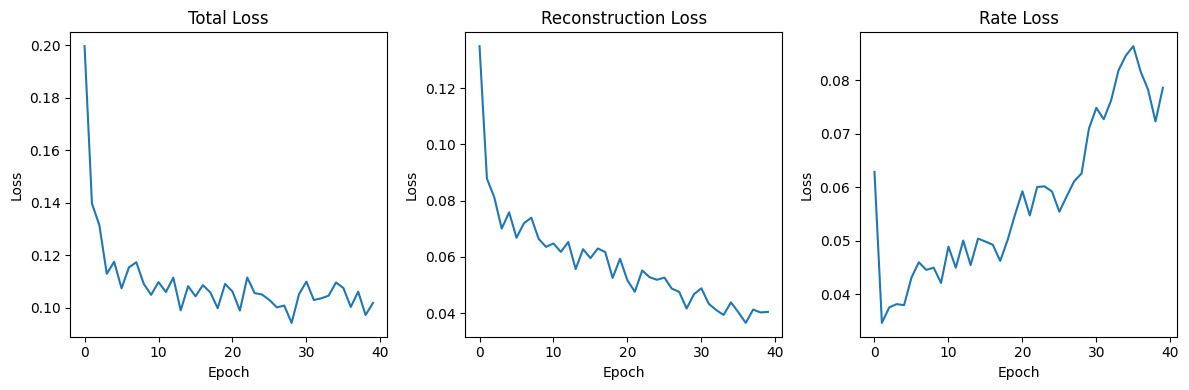

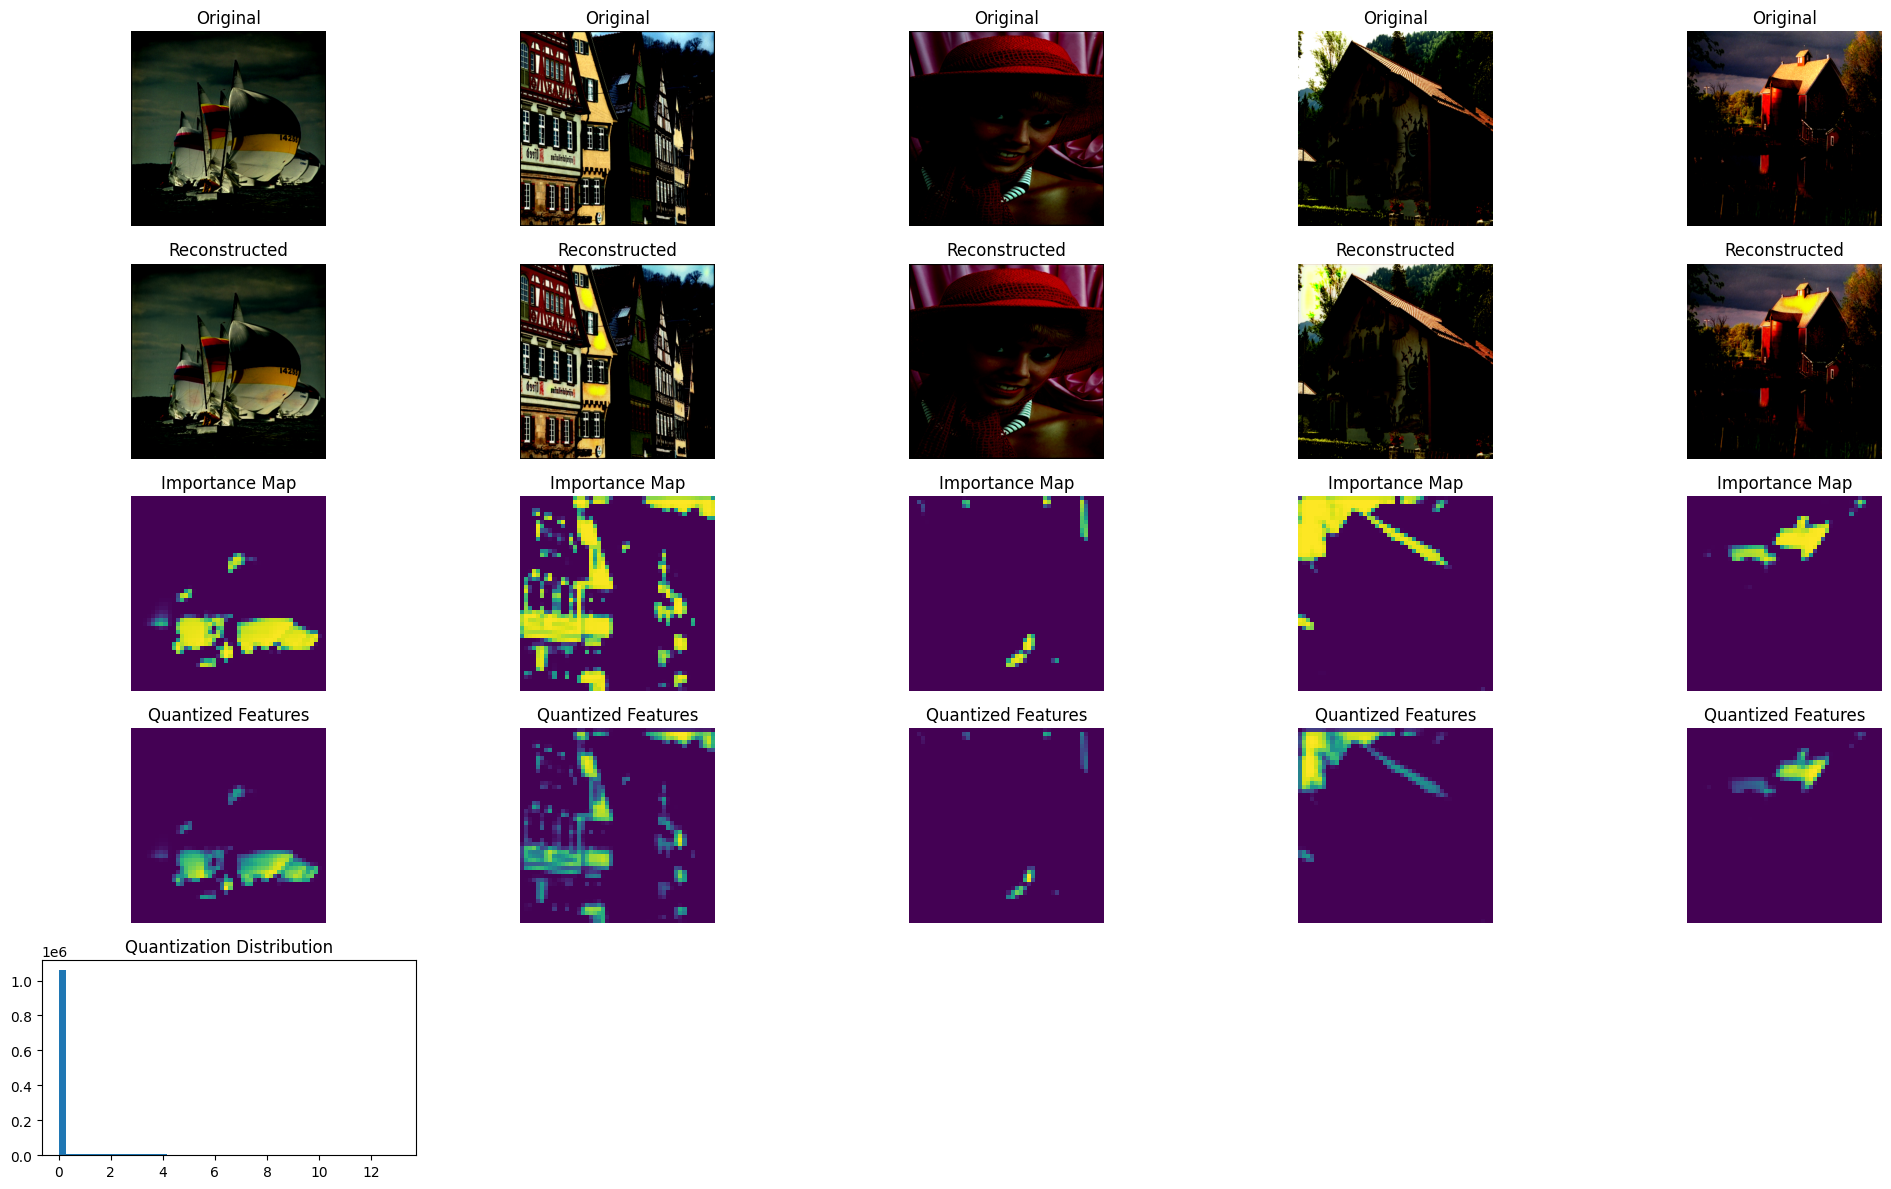

In [5]:
if __name__ == "__main__":
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
   
    # # Create data loader
    # train_dataset = KodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform)
    # train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)

    # Create data loader with upsampling
    train_dataset = UpsampledKodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform, num_samples=500)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
       
    # Setup training
    model, loss_function, optimizer, scheduler, device = create_training_setup()
   
    # Train the model
    history = train_model(model, train_loader, optimizer, scheduler, loss_function, device)
   
    # Plot training history
    plot_training_history(history)
   
    # Visualize results
    original_images, reconstructed_images, importance_maps, quantized_features = visualize_results(model, train_loader, device)
   
    # Plot comprehensive results
    plot_comprehensive_results(original_images, reconstructed_images, importance_maps, quantized_features)

Epoch [1/40], Batch [0/63], Total Loss: 0.706077, PSNR: 10.77, SSIM: -0.09
Epoch [1/40], Batch [10/63], Total Loss: 0.171071, PSNR: 22.02, SSIM: 0.51
Epoch [1/40], Batch [20/63], Total Loss: 0.150624, PSNR: 24.61, SSIM: 0.74
Epoch [1/40], Batch [30/63], Total Loss: 0.135869, PSNR: 25.92, SSIM: 0.78
Epoch [1/40], Batch [40/63], Total Loss: 0.175662, PSNR: 22.17, SSIM: 0.86
Epoch [1/40], Batch [50/63], Total Loss: 0.122093, PSNR: 24.78, SSIM: 0.75
Epoch [1/40], Batch [60/63], Total Loss: 0.240896, PSNR: 20.78, SSIM: 0.67
Epoch [2/40], Batch [0/63], Total Loss: 0.219770, PSNR: 23.45, SSIM: 0.68
Epoch [2/40], Batch [10/63], Total Loss: 0.194125, PSNR: 19.96, SSIM: 0.50
Epoch [2/40], Batch [20/63], Total Loss: 0.115608, PSNR: 28.03, SSIM: 0.84
Epoch [2/40], Batch [30/63], Total Loss: 0.118951, PSNR: 27.71, SSIM: 0.80
Epoch [2/40], Batch [40/63], Total Loss: 0.157768, PSNR: 23.21, SSIM: 0.76
Epoch [2/40], Batch [50/63], Total Loss: 0.112283, PSNR: 28.93, SSIM: 0.76
Epoch [2/40], Batch [60/63

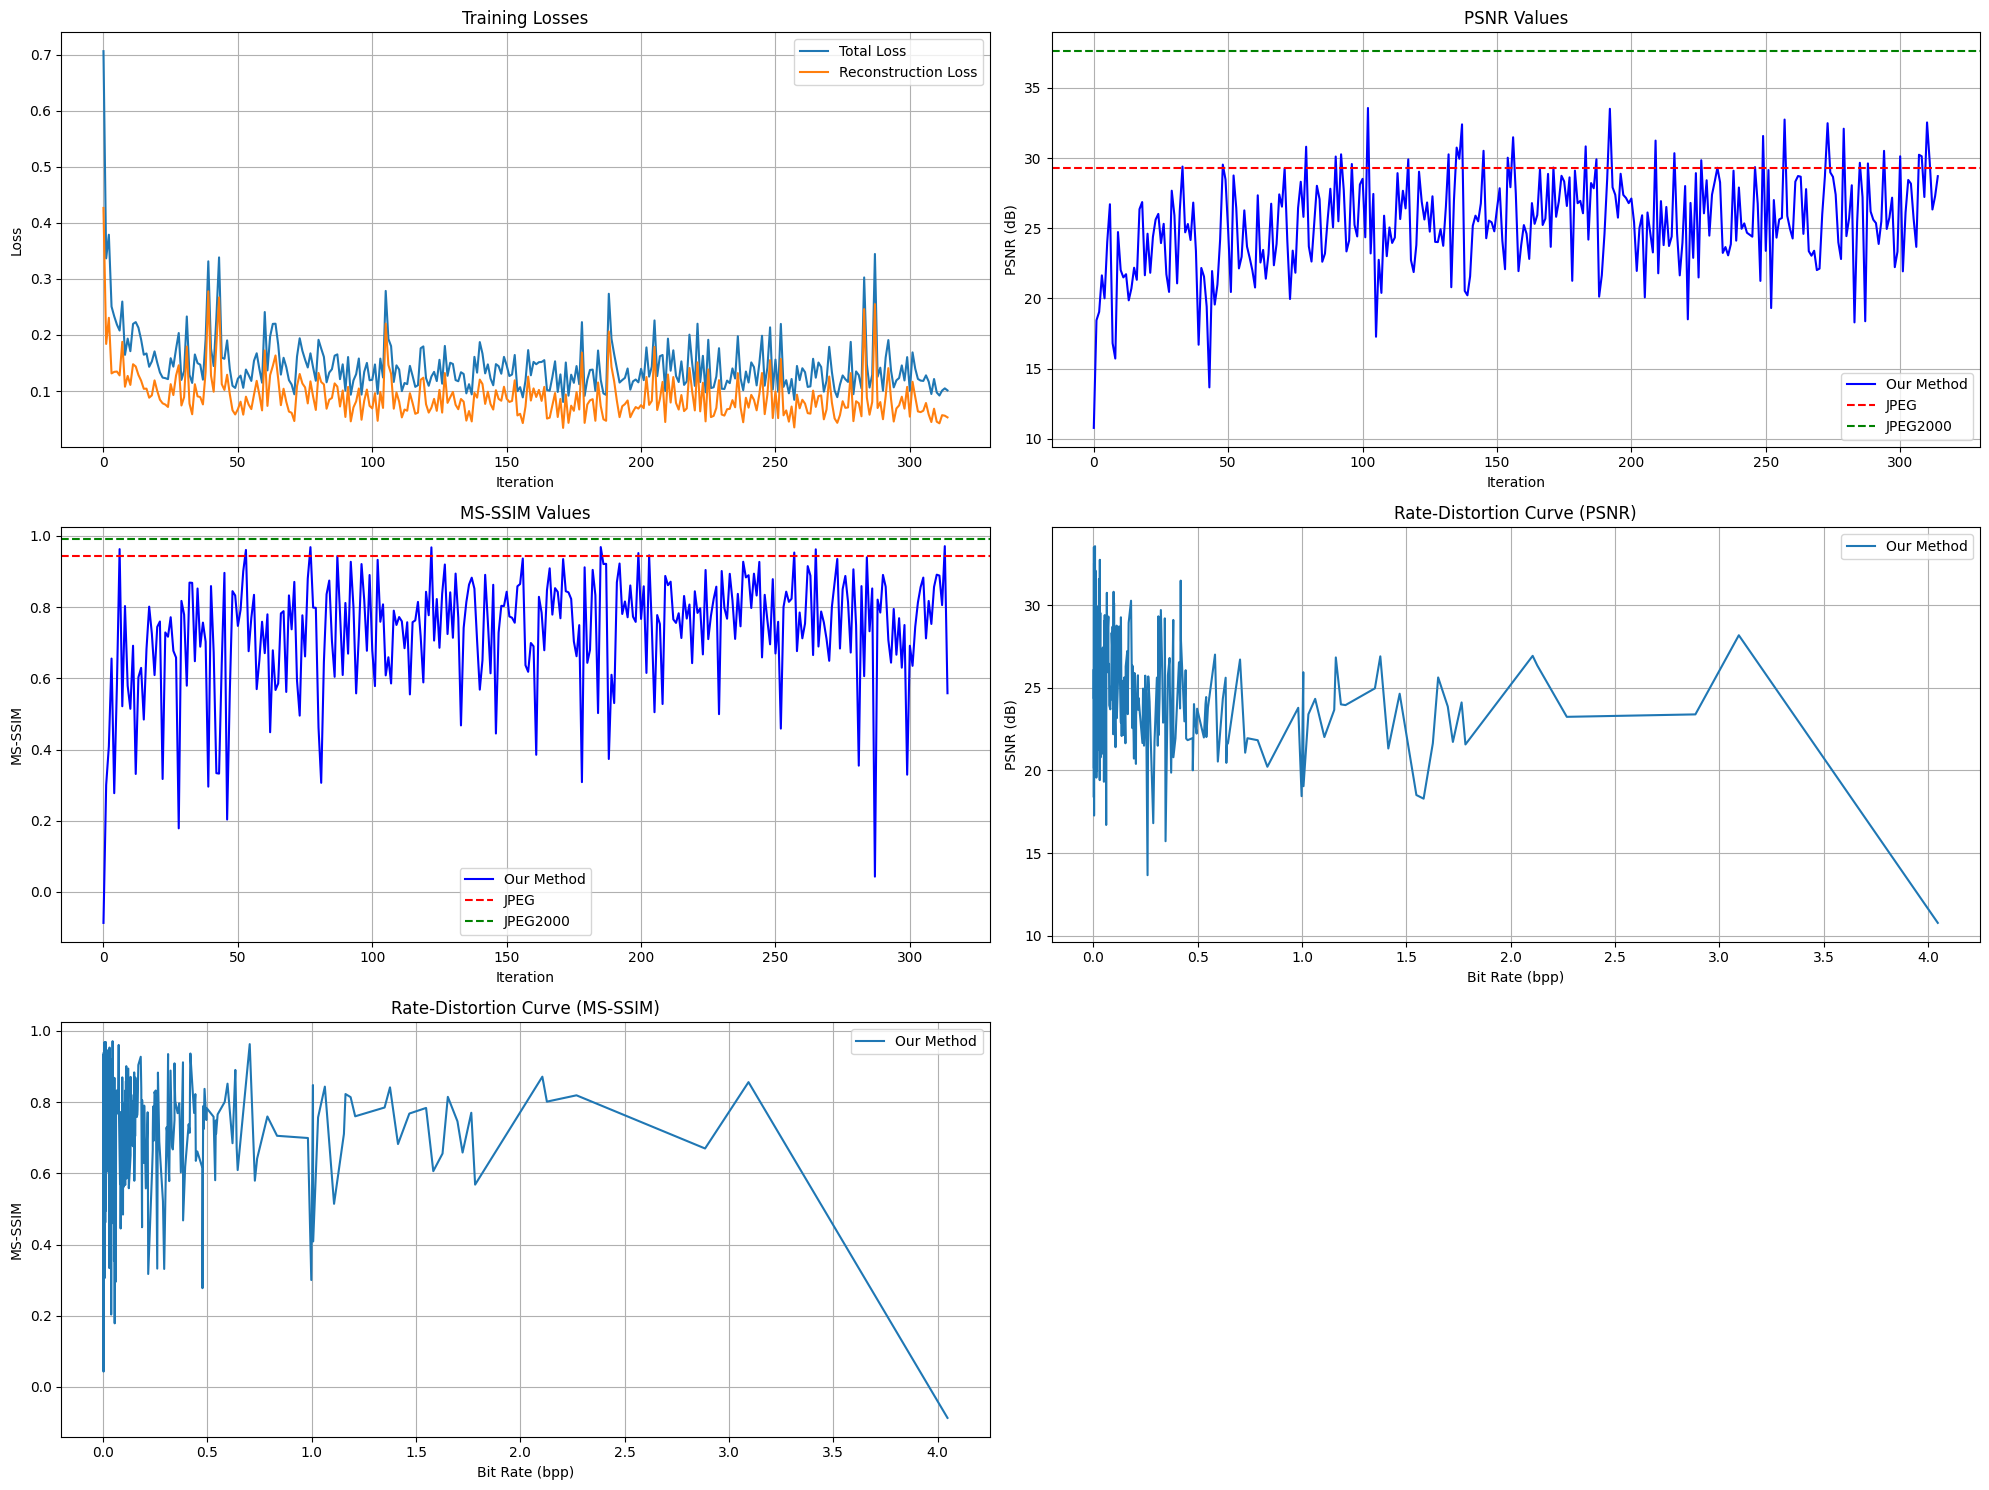

Epoch [6/40], Batch [0/63], Total Loss: 0.094086, PSNR: 31.80, SSIM: 0.93
Epoch [6/40], Batch [10/63], Total Loss: 0.088973, PSNR: 25.18, SSIM: 0.82
Epoch [6/40], Batch [20/63], Total Loss: 0.172360, PSNR: 23.64, SSIM: 0.43
Epoch [6/40], Batch [30/63], Total Loss: 0.131578, PSNR: 16.22, SSIM: 0.79
Epoch [6/40], Batch [40/63], Total Loss: 0.112224, PSNR: 30.17, SSIM: 0.91
Epoch [6/40], Batch [50/63], Total Loss: 0.112476, PSNR: 26.50, SSIM: 0.79
Epoch [6/40], Batch [60/63], Total Loss: 0.094233, PSNR: 30.54, SSIM: 0.92
Epoch [7/40], Batch [0/63], Total Loss: 0.094917, PSNR: 29.60, SSIM: 0.98
Epoch [7/40], Batch [10/63], Total Loss: 0.105535, PSNR: 28.29, SSIM: 0.84
Epoch [7/40], Batch [20/63], Total Loss: 0.092584, PSNR: 31.16, SSIM: 0.81
Epoch [7/40], Batch [30/63], Total Loss: 0.216345, PSNR: 22.54, SSIM: 0.56
Epoch [7/40], Batch [40/63], Total Loss: 0.086209, PSNR: 31.73, SSIM: 0.79
Epoch [7/40], Batch [50/63], Total Loss: 0.176271, PSNR: 23.68, SSIM: 0.37
Epoch [7/40], Batch [60/63]

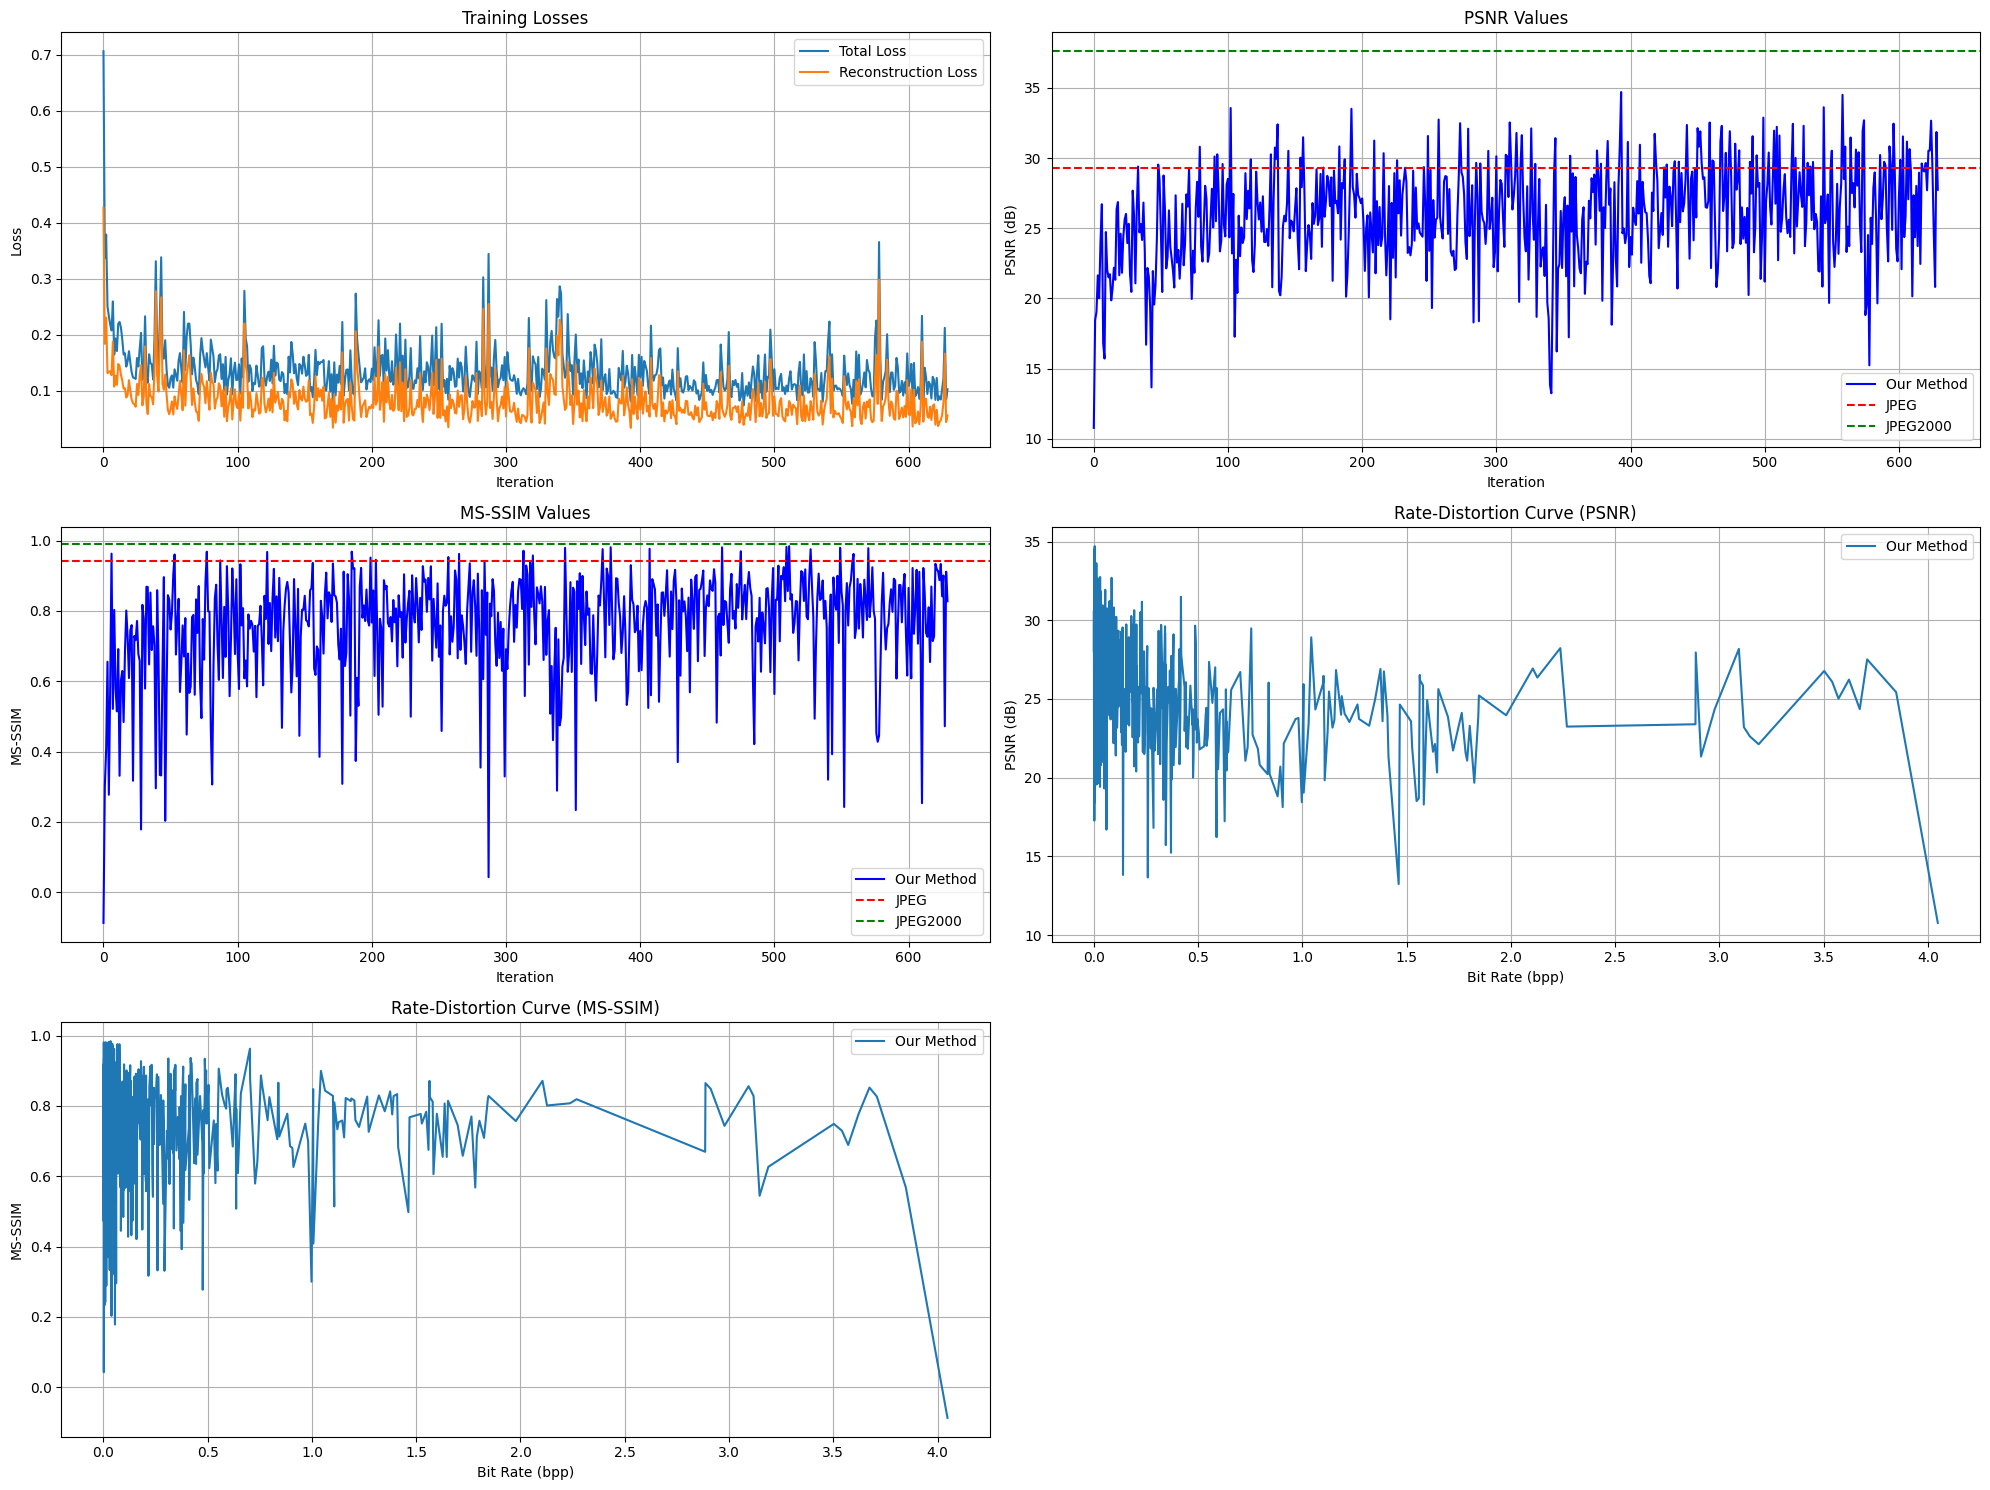

Epoch [11/40], Batch [0/63], Total Loss: 0.110507, PSNR: 27.51, SSIM: 0.81
Epoch [11/40], Batch [10/63], Total Loss: 0.136824, PSNR: 24.24, SSIM: 0.48
Epoch [11/40], Batch [20/63], Total Loss: 0.131716, PSNR: 25.57, SSIM: 0.73
Epoch [11/40], Batch [30/63], Total Loss: 0.116250, PSNR: 27.88, SSIM: 0.90
Epoch [11/40], Batch [40/63], Total Loss: 0.087864, PSNR: 25.98, SSIM: 0.82
Epoch [11/40], Batch [50/63], Total Loss: 0.129332, PSNR: 29.14, SSIM: 0.88
Epoch [11/40], Batch [60/63], Total Loss: 0.098870, PSNR: 26.34, SSIM: 0.90
Epoch [12/40], Batch [0/63], Total Loss: 0.086213, PSNR: 28.10, SSIM: 0.90
Epoch [12/40], Batch [10/63], Total Loss: 0.105863, PSNR: 25.50, SSIM: 0.86
Epoch [12/40], Batch [20/63], Total Loss: 0.105127, PSNR: 29.06, SSIM: 0.89
Epoch [12/40], Batch [30/63], Total Loss: 0.128626, PSNR: 30.11, SSIM: 0.82
Epoch [12/40], Batch [40/63], Total Loss: 0.134251, PSNR: 23.83, SSIM: 0.71
Epoch [12/40], Batch [50/63], Total Loss: 0.120170, PSNR: 28.18, SSIM: 0.89
Epoch [12/40],

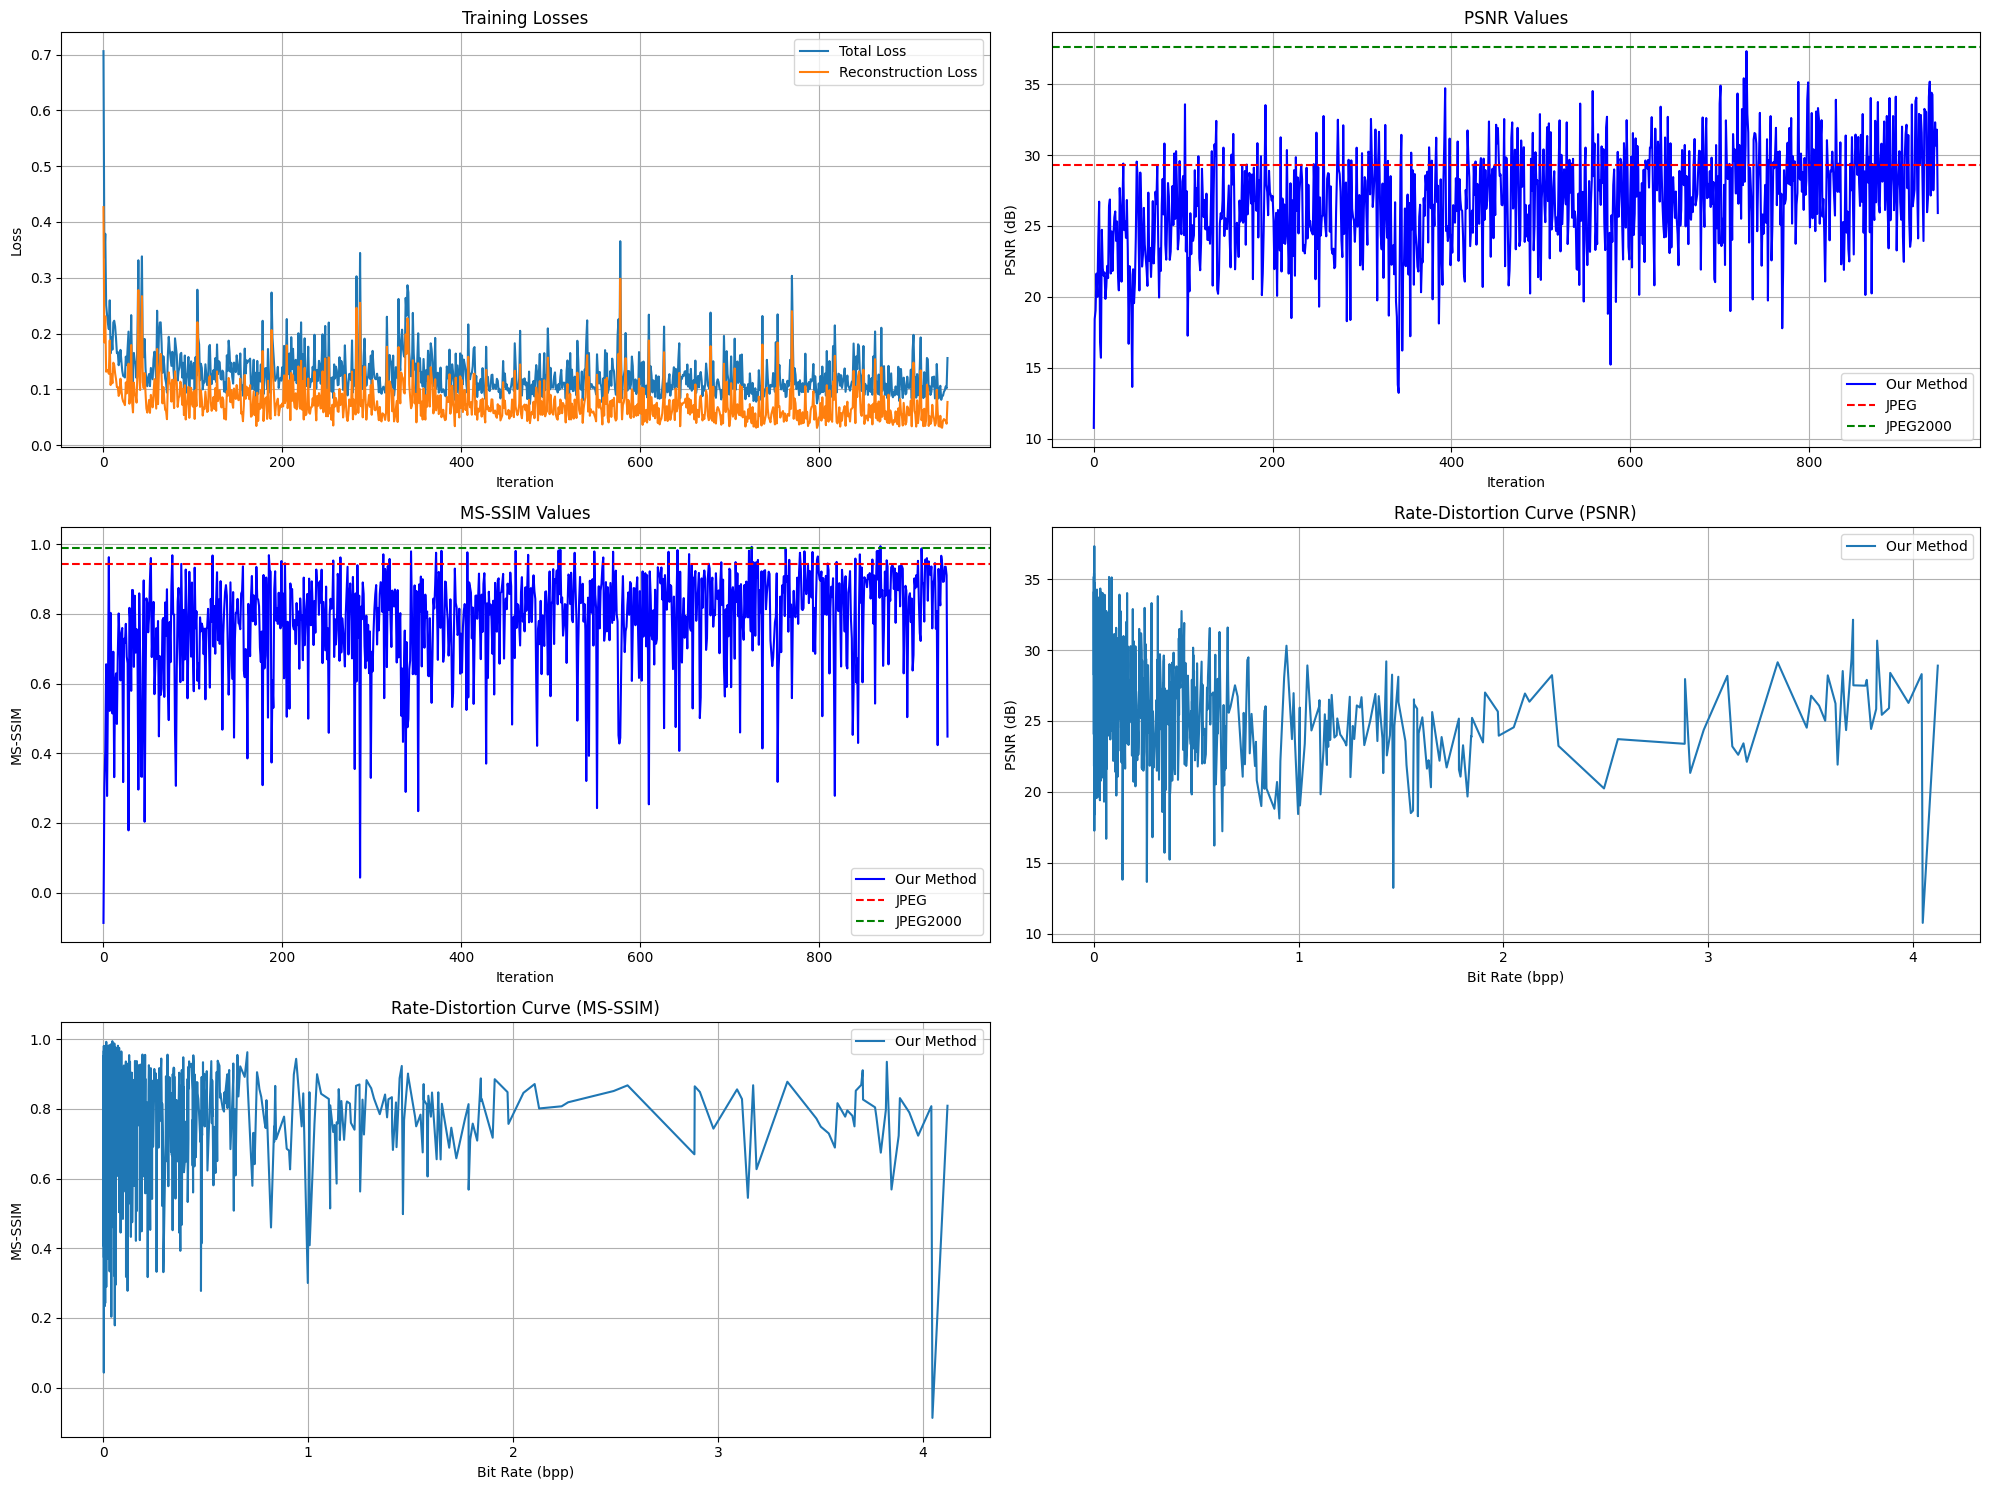

Epoch [16/40], Batch [0/63], Total Loss: 0.156623, PSNR: 27.24, SSIM: 0.88
Epoch [16/40], Batch [10/63], Total Loss: 0.091197, PSNR: 29.42, SSIM: 0.92
Epoch [16/40], Batch [20/63], Total Loss: 0.112077, PSNR: 29.00, SSIM: 0.89
Epoch [16/40], Batch [30/63], Total Loss: 0.109953, PSNR: 29.69, SSIM: 0.76
Epoch [16/40], Batch [40/63], Total Loss: 0.093857, PSNR: 30.29, SSIM: 0.93
Epoch [16/40], Batch [50/63], Total Loss: 0.088068, PSNR: 34.59, SSIM: 0.94
Epoch [16/40], Batch [60/63], Total Loss: 0.090568, PSNR: 32.05, SSIM: 0.94
Epoch [17/40], Batch [0/63], Total Loss: 0.116356, PSNR: 27.66, SSIM: 0.75
Epoch [17/40], Batch [10/63], Total Loss: 0.098648, PSNR: 29.71, SSIM: 0.90
Epoch [17/40], Batch [20/63], Total Loss: 0.117834, PSNR: 24.85, SSIM: 0.83
Epoch [17/40], Batch [30/63], Total Loss: 0.093142, PSNR: 31.07, SSIM: 0.93
Epoch [17/40], Batch [40/63], Total Loss: 0.132314, PSNR: 30.08, SSIM: 0.98
Epoch [17/40], Batch [50/63], Total Loss: 0.087871, PSNR: 32.04, SSIM: 0.94
Epoch [17/40],

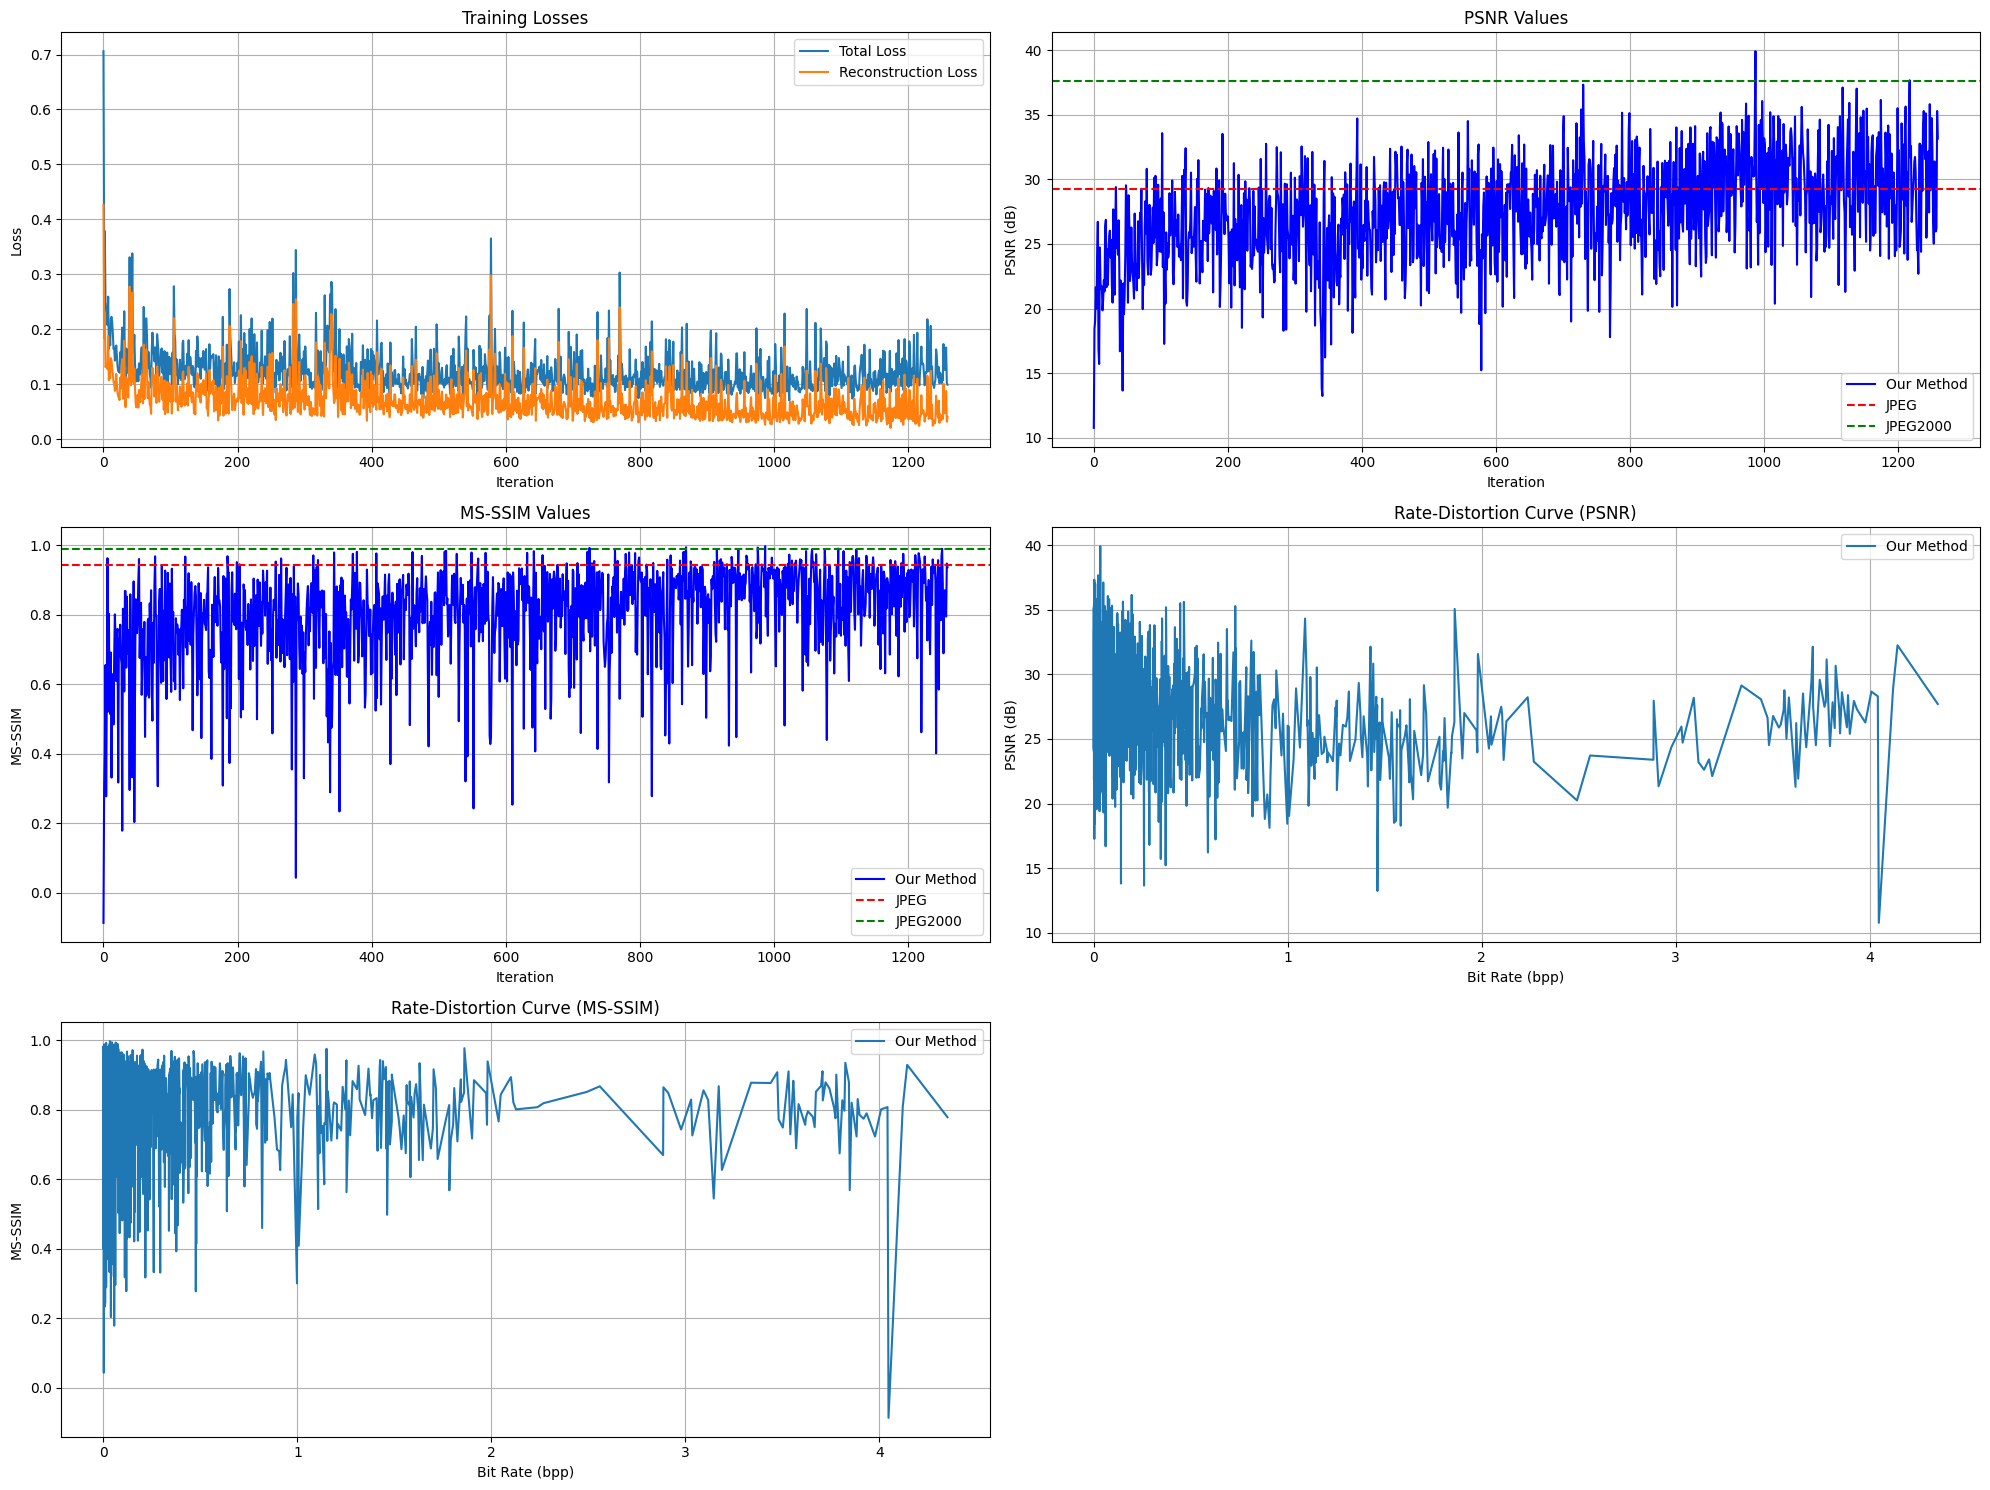

Epoch [21/40], Batch [0/63], Total Loss: 0.119241, PSNR: 30.73, SSIM: 0.77
Epoch [21/40], Batch [10/63], Total Loss: 0.096471, PSNR: 35.82, SSIM: 0.97
Epoch [21/40], Batch [20/63], Total Loss: 0.111523, PSNR: 32.87, SSIM: 0.79
Epoch [21/40], Batch [30/63], Total Loss: 0.142297, PSNR: 30.64, SSIM: 0.81
Epoch [21/40], Batch [40/63], Total Loss: 0.103595, PSNR: 29.13, SSIM: 0.79
Epoch [21/40], Batch [50/63], Total Loss: 0.121546, PSNR: 27.10, SSIM: 0.81
Epoch [21/40], Batch [60/63], Total Loss: 0.102965, PSNR: 29.87, SSIM: 0.93
Epoch [22/40], Batch [0/63], Total Loss: 0.094218, PSNR: 33.25, SSIM: 0.95
Epoch [22/40], Batch [10/63], Total Loss: 0.106982, PSNR: 29.61, SSIM: 0.93
Epoch [22/40], Batch [20/63], Total Loss: 0.122456, PSNR: 28.96, SSIM: 0.90
Epoch [22/40], Batch [30/63], Total Loss: 0.182918, PSNR: 26.85, SSIM: 0.86
Epoch [22/40], Batch [40/63], Total Loss: 0.142840, PSNR: 28.88, SSIM: 0.84
Epoch [22/40], Batch [50/63], Total Loss: 0.168297, PSNR: 26.47, SSIM: 0.85
Epoch [22/40],

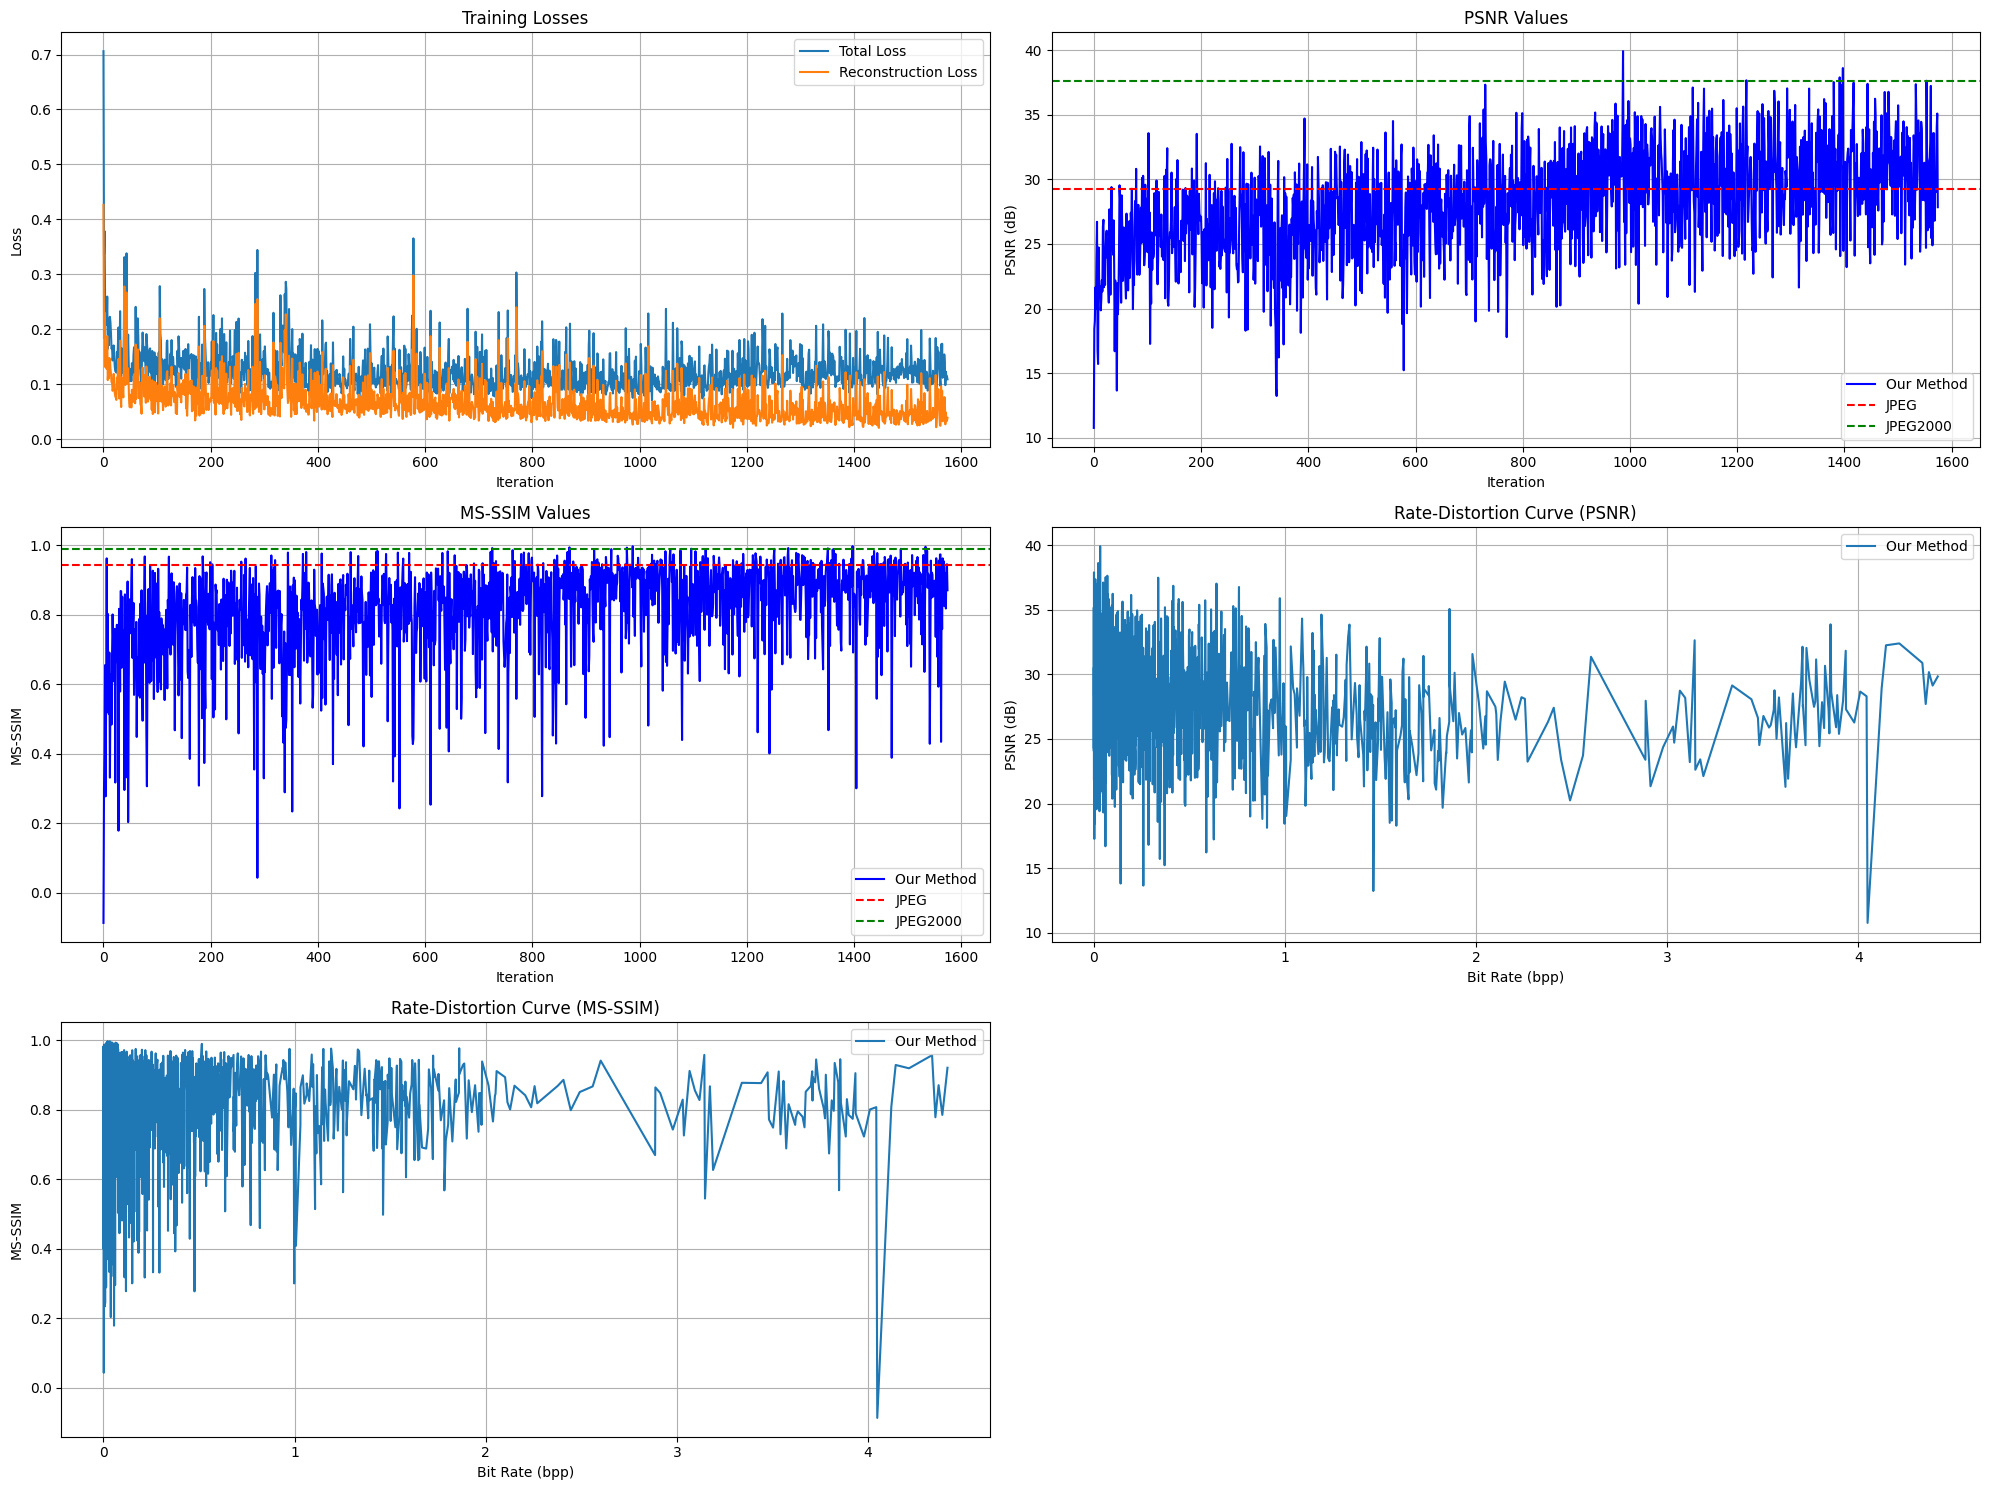

Epoch [26/40], Batch [0/63], Total Loss: 0.125413, PSNR: 28.95, SSIM: 0.88
Epoch [26/40], Batch [10/63], Total Loss: 0.121850, PSNR: 29.25, SSIM: 0.91
Epoch [26/40], Batch [20/63], Total Loss: 0.099124, PSNR: 36.86, SSIM: 0.98
Epoch [26/40], Batch [30/63], Total Loss: 0.137976, PSNR: 31.81, SSIM: 0.95
Epoch [26/40], Batch [40/63], Total Loss: 0.138162, PSNR: 30.59, SSIM: 0.88
Epoch [26/40], Batch [50/63], Total Loss: 0.172237, PSNR: 25.40, SSIM: 0.55
Epoch [26/40], Batch [60/63], Total Loss: 0.142780, PSNR: 28.22, SSIM: 0.85
Epoch [27/40], Batch [0/63], Total Loss: 0.121094, PSNR: 30.82, SSIM: 0.68
Epoch [27/40], Batch [10/63], Total Loss: 0.187919, PSNR: 27.45, SSIM: 0.90
Epoch [27/40], Batch [20/63], Total Loss: 0.127039, PSNR: 28.20, SSIM: 0.61
Epoch [27/40], Batch [30/63], Total Loss: 0.107833, PSNR: 36.82, SSIM: 0.93
Epoch [27/40], Batch [40/63], Total Loss: 0.144743, PSNR: 28.36, SSIM: 0.84
Epoch [27/40], Batch [50/63], Total Loss: 0.105827, PSNR: 34.45, SSIM: 0.92
Epoch [27/40],

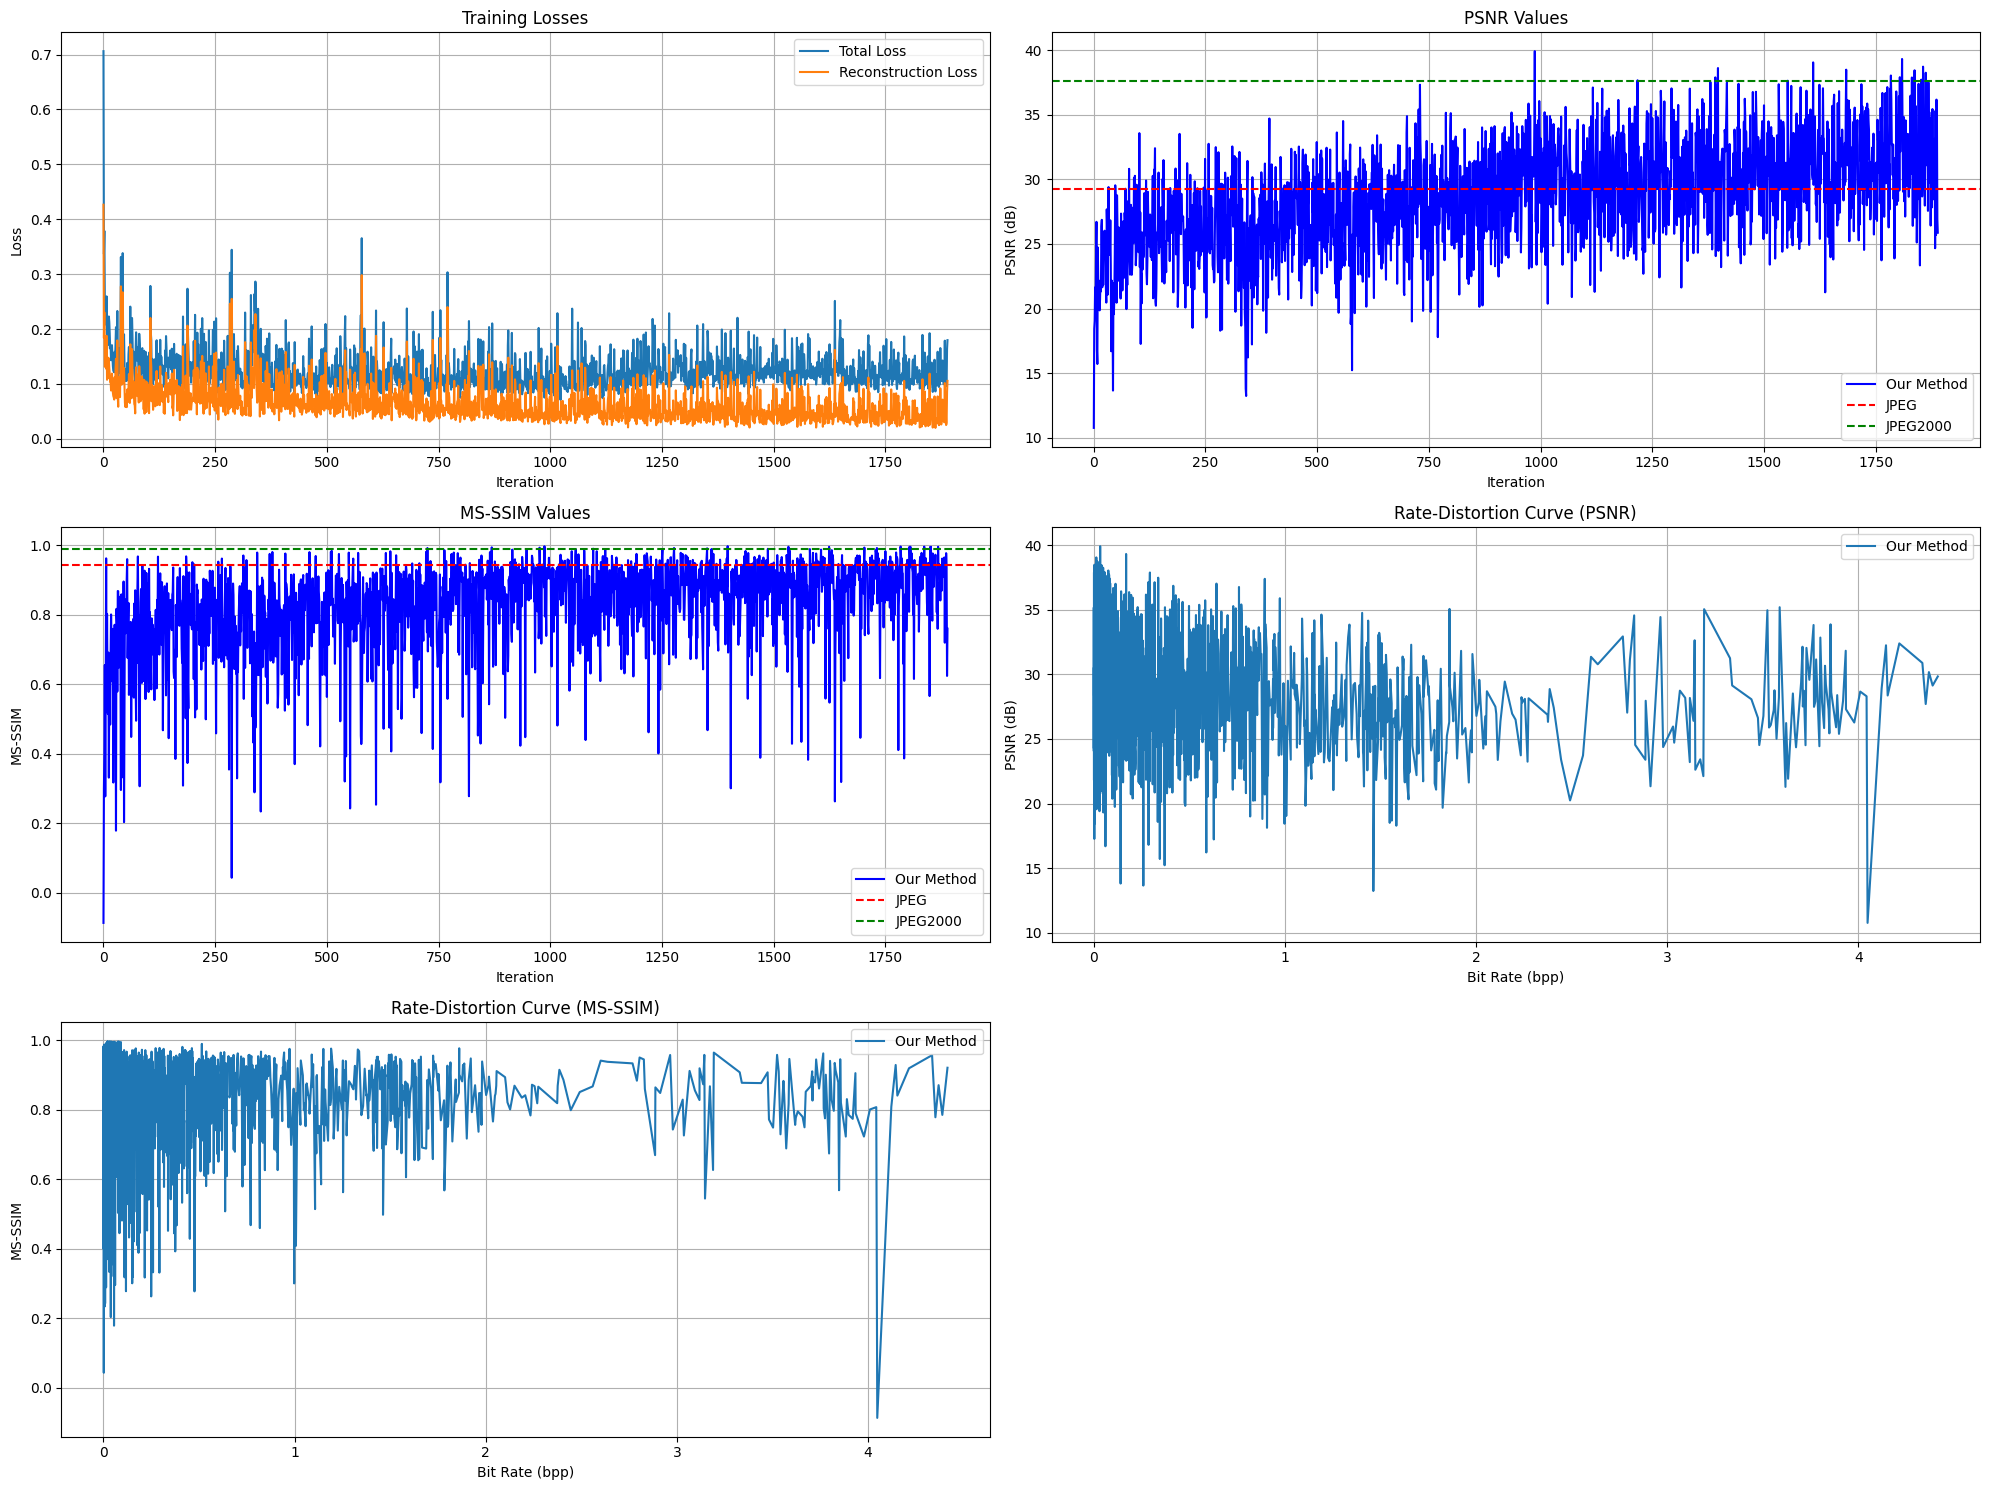

Epoch [31/40], Batch [0/63], Total Loss: 0.097718, PSNR: 33.82, SSIM: 0.95
Epoch [31/40], Batch [10/63], Total Loss: 0.104975, PSNR: 34.42, SSIM: 0.91
Epoch [31/40], Batch [20/63], Total Loss: 0.093321, PSNR: 35.19, SSIM: 0.96
Epoch [31/40], Batch [30/63], Total Loss: 0.101604, PSNR: 31.26, SSIM: 0.96
Epoch [31/40], Batch [40/63], Total Loss: 0.097127, PSNR: 35.40, SSIM: 0.94
Epoch [31/40], Batch [50/63], Total Loss: 0.120533, PSNR: 28.72, SSIM: 0.88
Epoch [31/40], Batch [60/63], Total Loss: 0.109530, PSNR: 33.59, SSIM: 0.90
Epoch [32/40], Batch [0/63], Total Loss: 0.112382, PSNR: 30.26, SSIM: 0.88
Epoch [32/40], Batch [10/63], Total Loss: 0.100717, PSNR: 33.59, SSIM: 0.94
Epoch [32/40], Batch [20/63], Total Loss: 0.090238, PSNR: 37.12, SSIM: 0.96
Epoch [32/40], Batch [30/63], Total Loss: 0.109380, PSNR: 27.77, SSIM: 0.90
Epoch [32/40], Batch [40/63], Total Loss: 0.116064, PSNR: 29.95, SSIM: 0.86
Epoch [32/40], Batch [50/63], Total Loss: 0.161315, PSNR: 28.06, SSIM: 0.91
Epoch [32/40],

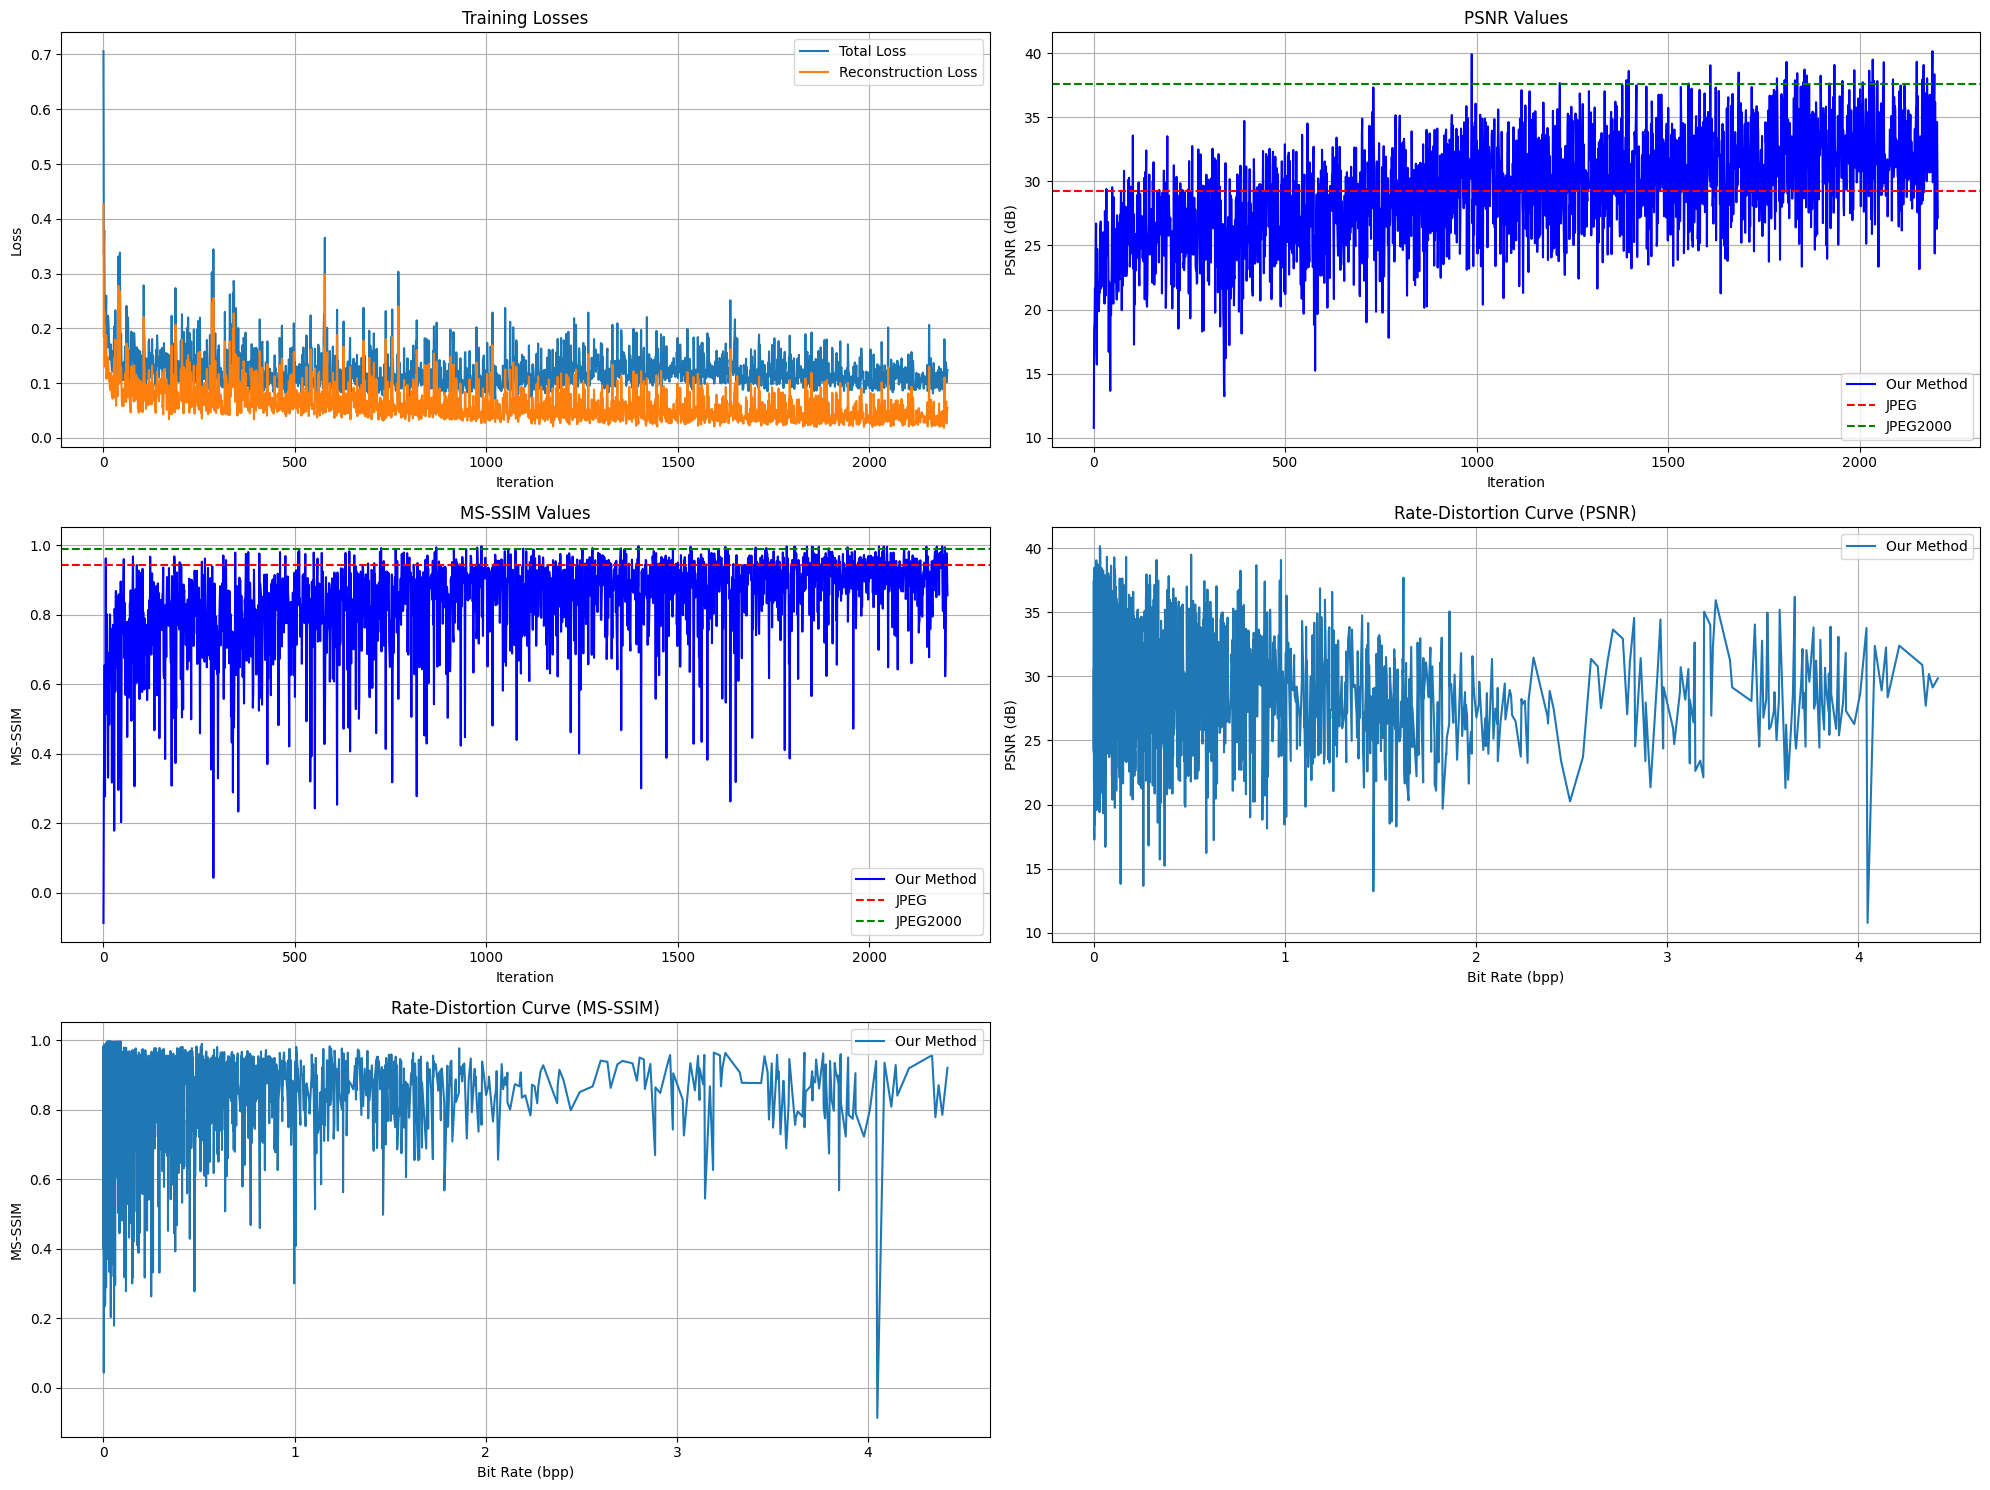

Epoch [36/40], Batch [0/63], Total Loss: 0.085961, PSNR: 37.30, SSIM: 0.96
Epoch [36/40], Batch [10/63], Total Loss: 0.113408, PSNR: 30.04, SSIM: 0.92
Epoch [36/40], Batch [20/63], Total Loss: 0.104696, PSNR: 31.43, SSIM: 0.95
Epoch [36/40], Batch [30/63], Total Loss: 0.096894, PSNR: 29.75, SSIM: 0.95
Epoch [36/40], Batch [40/63], Total Loss: 0.094136, PSNR: 35.25, SSIM: 0.97
Epoch [36/40], Batch [50/63], Total Loss: 0.120410, PSNR: 34.42, SSIM: 0.93
Epoch [36/40], Batch [60/63], Total Loss: 0.094030, PSNR: 32.97, SSIM: 0.92
Epoch [37/40], Batch [0/63], Total Loss: 0.096705, PSNR: 30.58, SSIM: 0.93
Epoch [37/40], Batch [10/63], Total Loss: 0.095766, PSNR: 36.65, SSIM: 0.96
Epoch [37/40], Batch [20/63], Total Loss: 0.092163, PSNR: 35.25, SSIM: 1.00
Epoch [37/40], Batch [30/63], Total Loss: 0.148210, PSNR: 28.71, SSIM: 0.89
Epoch [37/40], Batch [40/63], Total Loss: 0.115327, PSNR: 35.78, SSIM: 0.93
Epoch [37/40], Batch [50/63], Total Loss: 0.114602, PSNR: 30.60, SSIM: 0.76
Epoch [37/40],

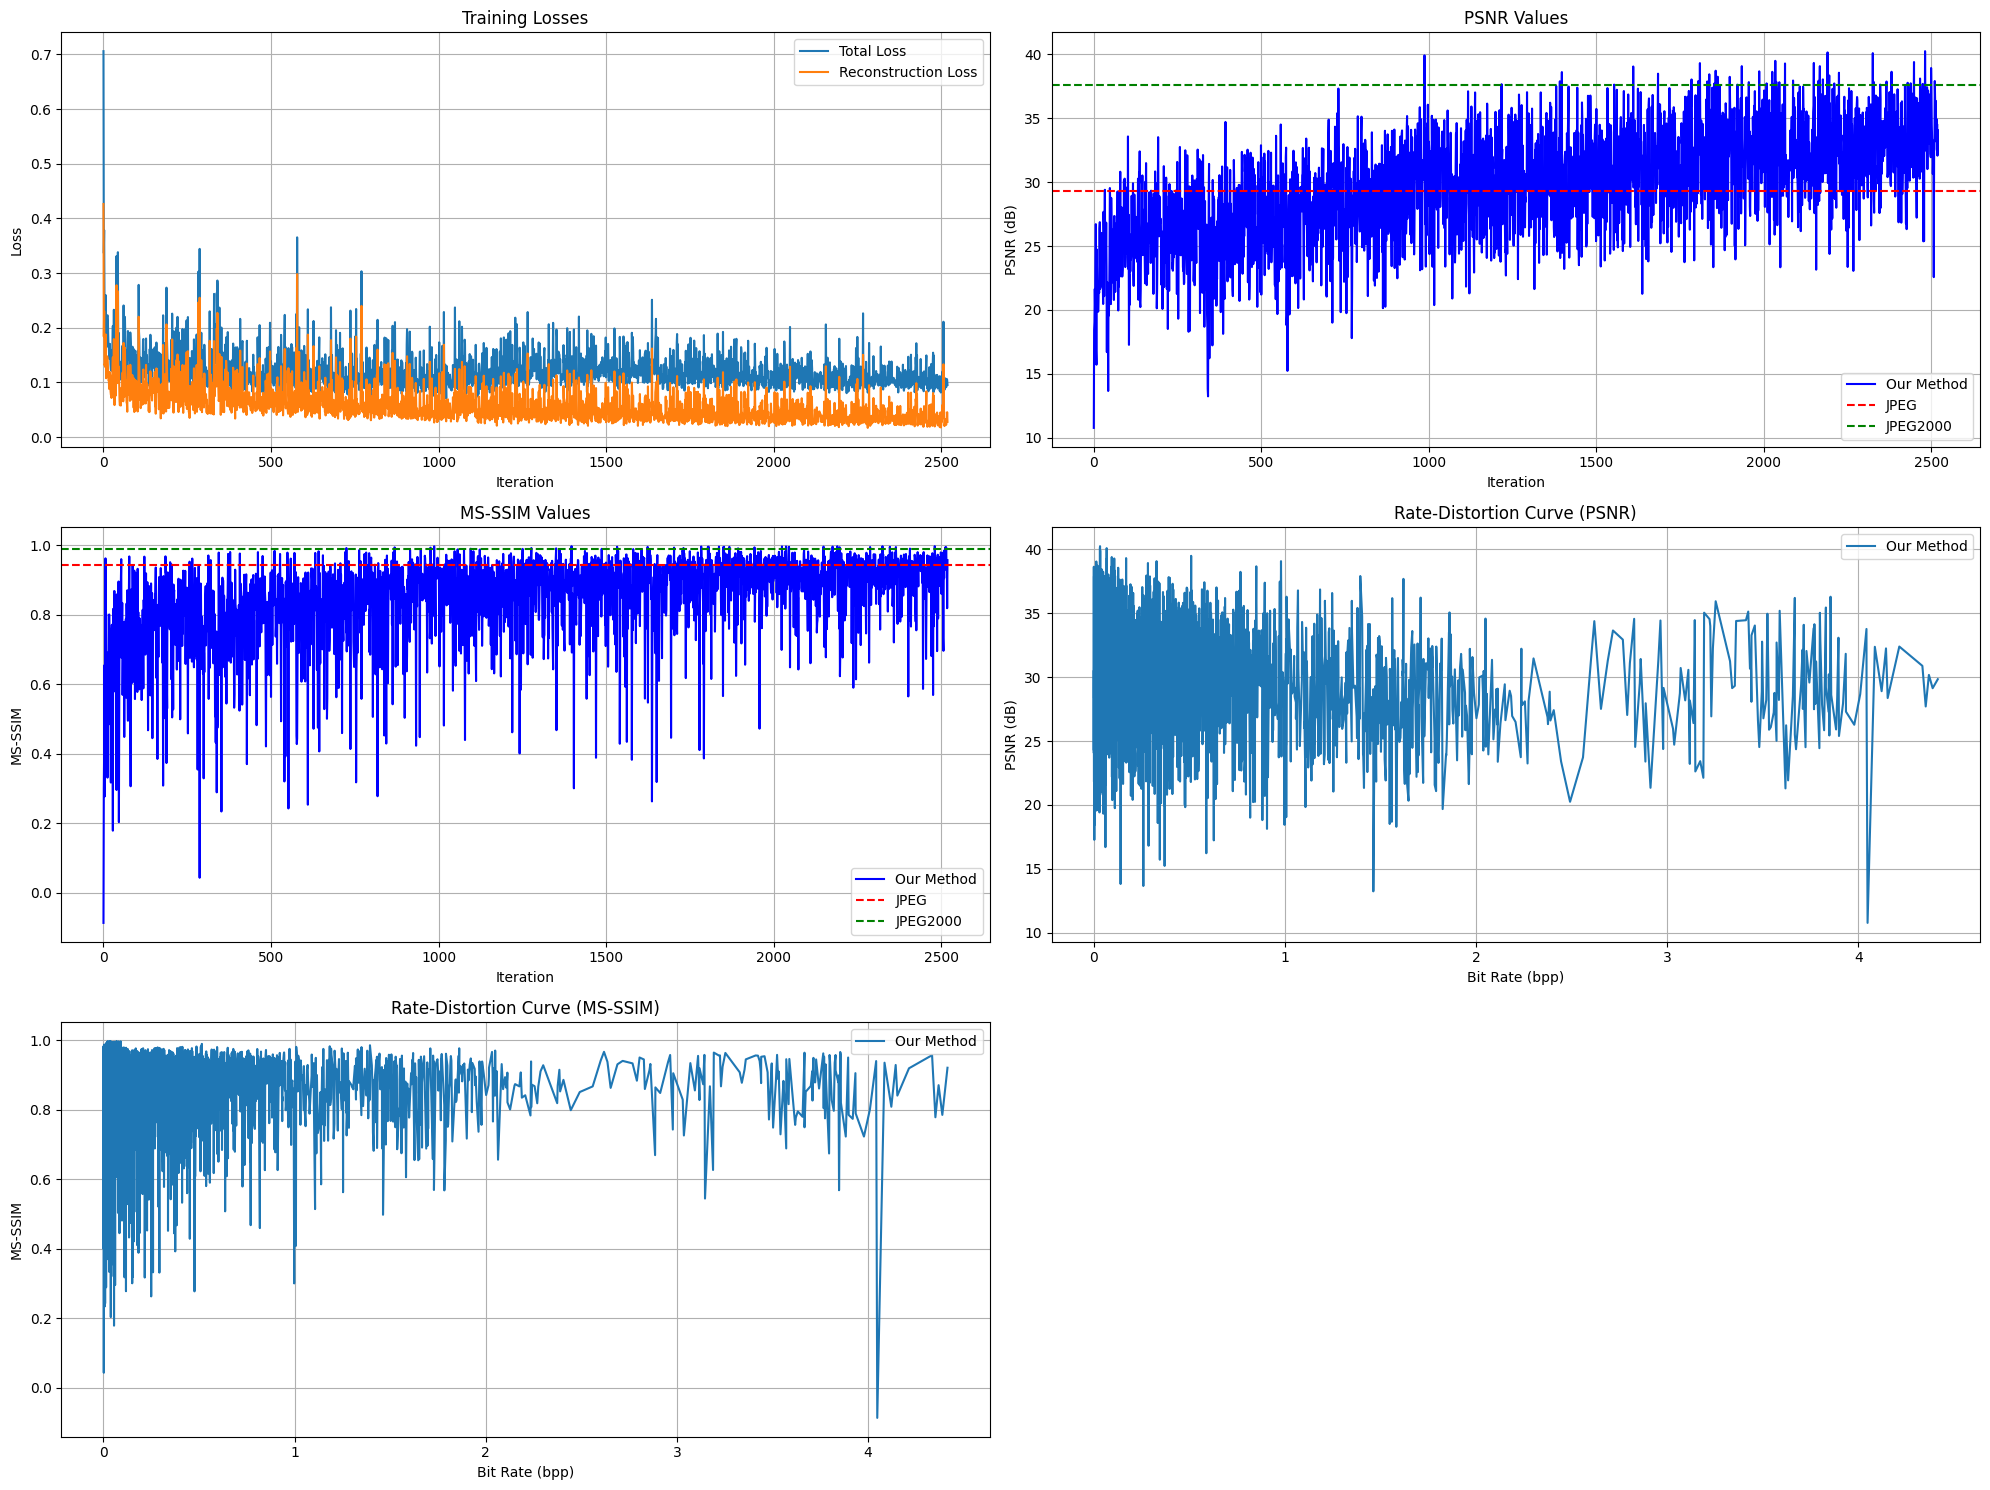

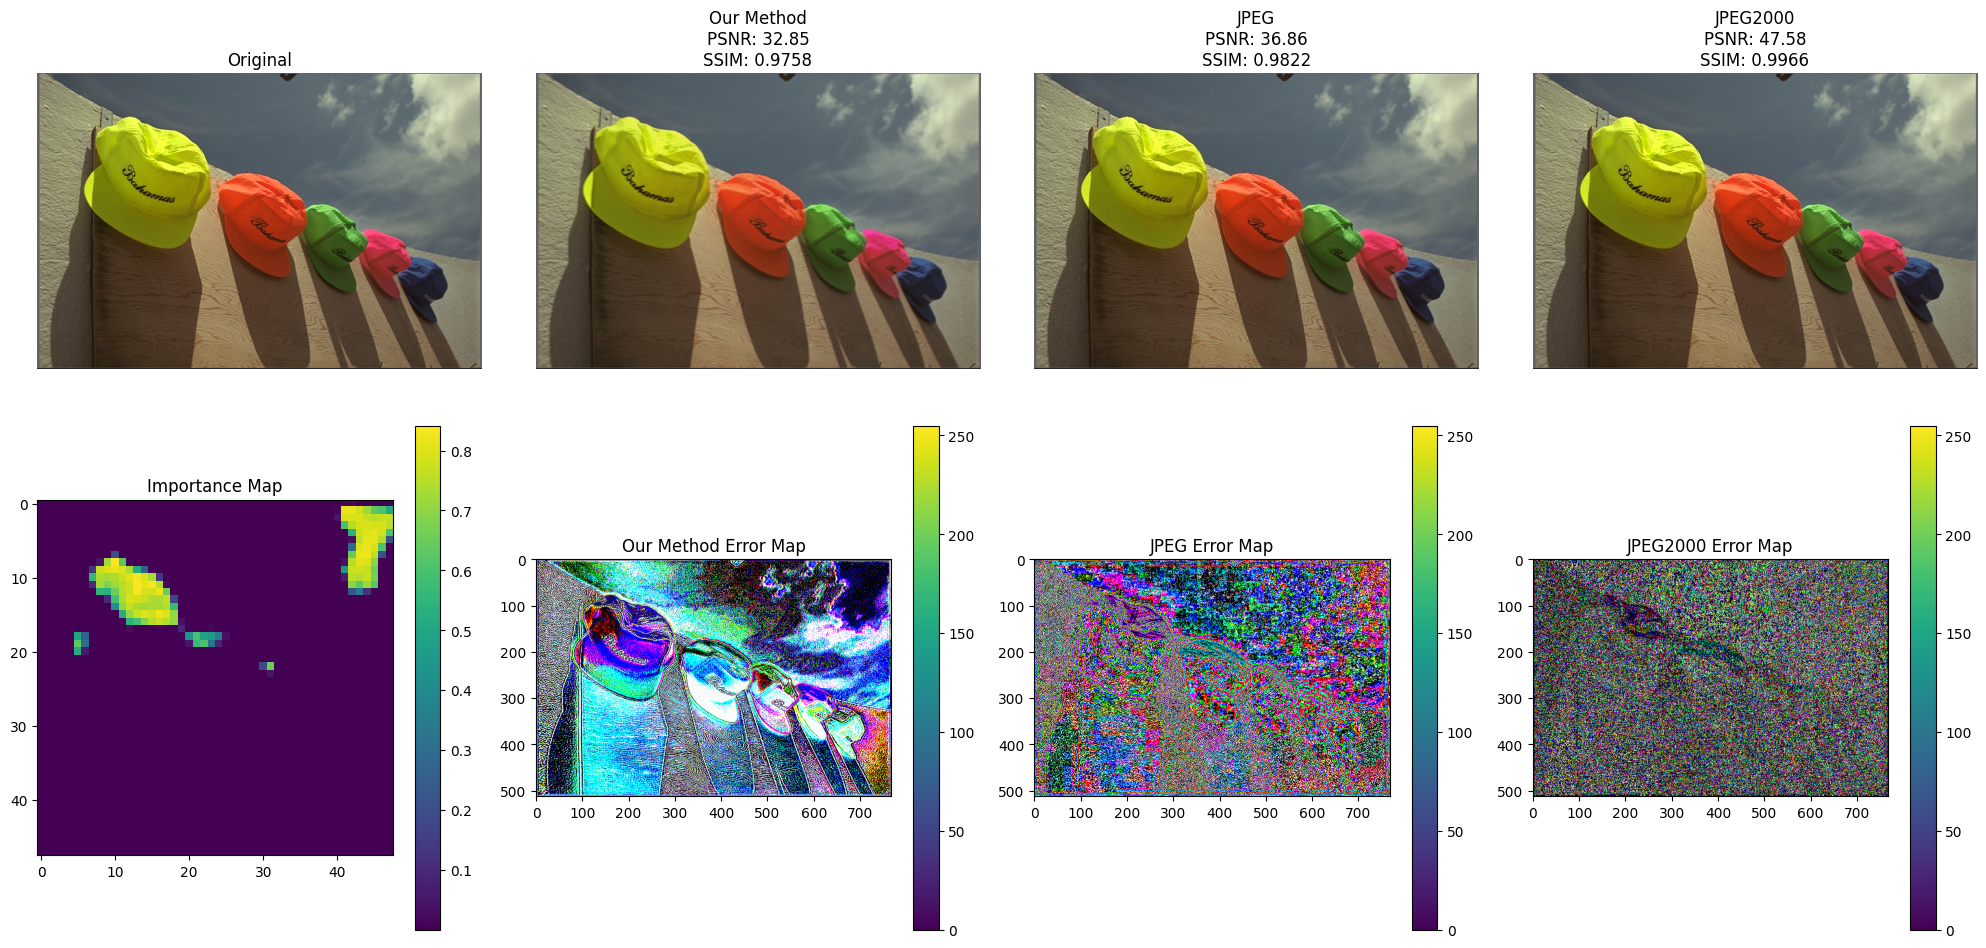

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import pandas as pd
import seaborn as sns

# Keep all existing model classes (MultiFrequencyChannelAttention, PMCNModule, etc.)
# [Previous model implementation code remains the same...]

class MetricsTracker:
    def __init__(self):
        self.psnr_values = []
        self.ssim_values = []
        self.bit_rates = []
        self.total_losses = []
        self.reconstruction_losses = []
        self.rate_losses = []
        self.quantization_losses = []
        
    def update(self, original, reconstructed, importance_map, losses):
        psnr_val, ssim_val = self.calculate_metrics(original, reconstructed)
        bit_rate = self.calculate_bit_rate(importance_map)
        
        self.psnr_values.append(psnr_val)
        self.ssim_values.append(ssim_val)
        self.bit_rates.append(bit_rate)
        
        # Store all losses
        self.total_losses.append(losses[0])
        self.reconstruction_losses.append(losses[1])
        self.rate_losses.append(losses[2])
        self.quantization_losses.append(losses[3])
    
    @staticmethod
    def calculate_metrics(original, reconstructed):
        """Calculate PSNR and SSIM metrics."""
        if torch.is_tensor(original):
            original = original.cpu().detach().numpy()
        if torch.is_tensor(reconstructed):
            reconstructed = reconstructed.cpu().detach().numpy()
        
        original = np.transpose(original, (1, 2, 0))
        reconstructed = np.transpose(reconstructed, (1, 2, 0))
        
        if original.max() <= 1.0:
            original = original * 255.0
        if reconstructed.max() <= 1.0:
            reconstructed = reconstructed * 255.0
        
        # Calculate data_range
        data_range = np.max(original) - np.min(original)
        
        psnr_value = psnr(original, reconstructed, data_range=data_range)
        
        # Set win_size to a smaller value (e.g., 3) for smaller images
        ssim_value = ssim(original, reconstructed, win_size=3, data_range=data_range, multichannel=True)
        
        return psnr_value, ssim_value
    
    @staticmethod
    def calculate_bit_rate(importance_map):
        if torch.is_tensor(importance_map):
            importance_map = importance_map.cpu().detach().numpy()
        return np.mean(importance_map) * 8

def plot_comprehensive_training_results(metrics_tracker):
    """Plot all training metrics including losses, PSNR, SSIM, and rate-distortion curves."""
    plt.figure(figsize=(20, 15))
    
    # Plot losses
    plt.subplot(3, 2, 1)
    plt.plot(metrics_tracker.total_losses, label='Total Loss')
    plt.plot(metrics_tracker.reconstruction_losses, label='Reconstruction Loss')
    plt.title('Training Losses')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot PSNR
    plt.subplot(3, 2, 2)
    plt.plot(metrics_tracker.psnr_values, 'b-', label='Our Method')
    plt.axhline(y=29.28, color='r', linestyle='--', label='JPEG')
    plt.axhline(y=37.62, color='g', linestyle='--', label='JPEG2000')
    plt.title('PSNR Values')
    plt.xlabel('Iteration')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)
    
    # Plot SSIM
    plt.subplot(3, 2, 3)
    plt.plot(metrics_tracker.ssim_values, 'b-', label='Our Method')
    plt.axhline(y=0.9423, color='r', linestyle='--', label='JPEG')
    plt.axhline(y=0.9900, color='g', linestyle='--', label='JPEG2000')
    plt.title('MS-SSIM Values')
    plt.xlabel('Iteration')
    plt.ylabel('MS-SSIM')
    plt.legend()
    plt.grid(True)
    
    # Plot Rate-Distortion (PSNR)
    plt.subplot(3, 2, 4)
    bit_rates = np.array(metrics_tracker.bit_rates)
    psnr_values = np.array(metrics_tracker.psnr_values)
    idx = np.argsort(bit_rates)
    plt.plot(bit_rates[idx], psnr_values[idx], label='Our Method')
    plt.title('Rate-Distortion Curve (PSNR)')
    plt.xlabel('Bit Rate (bpp)')
    plt.ylabel('PSNR (dB)')
    plt.legend()
    plt.grid(True)

    # Plot Rate-Distortion (SSIM)
    plt.subplot(3, 2, 5)
    bit_rates = np.array(metrics_tracker.bit_rates)
    ssim_values = np.array(metrics_tracker.ssim_values)
    idx = np.argsort(bit_rates)
    plt.plot(bit_rates[idx], ssim_values[idx], label='Our Method')
    plt.title('Rate-Distortion Curve (MS-SSIM)')
    plt.xlabel('Bit Rate (bpp)')
    plt.ylabel('MS-SSIM')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def enhanced_train_model(model, train_loader, optimizer, scheduler, loss_function, device, num_epochs=40):
    """Enhanced training loop with comprehensive metrics tracking."""
    model.train()
    metrics_tracker = MetricsTracker()
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_losses = {
            'total': 0.0,
            'reconstruction': 0.0,
            'rate': 0.0,
            'quantization': 0.0
        }
        
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            reconstructed, importance_map, quantized = model(images)
            
            # Calculate losses
            total_loss, recon_loss, rate_loss, quant_loss = loss_function(
                images, reconstructed, importance_map, model.encoder(images)[0], quantized
            )
            
            # Backward pass
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            # Update metrics
            metrics_tracker.update(
                images[0],
                reconstructed[0],
                importance_map[0],
                (total_loss.item(), recon_loss.item(), rate_loss.item(), quant_loss.item())
            )
            
            # Update running losses
            running_losses['total'] += total_loss.item()
            running_losses['reconstruction'] += recon_loss.item()
            running_losses['rate'] += rate_loss.item()
            running_losses['quantization'] += quant_loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Total Loss: {total_loss.item():.6f}, PSNR: {metrics_tracker.psnr_values[-1]:.2f}, SSIM: {metrics_tracker.ssim_values[-1]:.2f}')
        
        # Calculate average losses for the epoch
        avg_total_loss = running_losses['total'] / len(train_loader)
        
        # Learning rate scheduling
        scheduler.step(avg_total_loss)
        
        # Save best model
        if avg_total_loss < best_loss:
            best_loss = avg_total_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'metrics': {
                    'psnr': metrics_tracker.psnr_values,
                    'ssim': metrics_tracker.ssim_values,
                    'bit_rates': metrics_tracker.bit_rates
                }
            }, 'best_model.pth')
        
        # Plot comprehensive results every 5 epochs
        if (epoch + 1) % 5 == 0:
            plot_comprehensive_training_results(metrics_tracker)
    
    return metrics_tracker
def visualize_compression_comparison(model, image_path, device, jpeg_quality=75):
    """Compare visual quality between our method, JPEG, and JPEG2000."""
    original = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_tensor = transform(original).unsqueeze(0).to(device)
    
    # Our method
    model.eval()
    with torch.no_grad():
        reconstructed, importance_map, _ = model(img_tensor)
        reconstructed = reconstructed.squeeze().cpu().numpy()
        reconstructed = np.transpose(reconstructed, (1, 2, 0))
        reconstructed = (reconstructed + 1) * 127.5
    
    # Resize reconstructed image to match original size
    reconstructed = cv2.resize(reconstructed, (original.width, original.height), interpolation=cv2.INTER_CUBIC)
    
    # JPEG compression
    jpeg_path = 'temp_jpeg.jpg'
    original.save(jpeg_path, quality=jpeg_quality)
    jpeg_img = Image.open(jpeg_path)
    
    # JPEG2000 compression
    original_cv = cv2.cvtColor(np.array(original), cv2.COLOR_RGB2BGR)
    _, jpeg2k = cv2.imencode('.jp2', original_cv)
    jpeg2k_img = cv2.imdecode(jpeg2k, cv2.IMREAD_COLOR)
    jpeg2k_img = cv2.cvtColor(jpeg2k_img, cv2.COLOR_BGR2RGB)
    
    # Calculate metrics for each method
    metrics = {
        'Original': (None, None),  # Reference
        'Our Method': MetricsTracker.calculate_metrics(np.array(original), reconstructed),
        'JPEG': MetricsTracker.calculate_metrics(np.array(original), np.array(jpeg_img)),
        'JPEG2000': MetricsTracker.calculate_metrics(np.array(original), jpeg2k_img)
    }
    
    # Visualization
    plt.figure(figsize=(20, 10))
    
    # Plot images
    plt.subplot(2, 4, 1)
    plt.imshow(original)
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 4, 2)
    plt.imshow(reconstructed.astype(np.uint8))
    plt.title(f'Our Method\nPSNR: {metrics["Our Method"][0]:.2f}\nSSIM: {metrics["Our Method"][1]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 4, 3)
    plt.imshow(jpeg_img)
    plt.title(f'JPEG\nPSNR: {metrics["JPEG"][0]:.2f}\nSSIM: {metrics["JPEG"][1]:.4f}')
    plt.axis('off')
    
    plt.subplot(2, 4, 4)
    plt.imshow(jpeg2k_img)
    plt.title(f'JPEG2000\nPSNR: {metrics["JPEG2000"][0]:.2f}\nSSIM: {metrics["JPEG2000"][1]:.4f}')
    plt.axis('off')
    
    # Importance map and error visualizations
    plt.subplot(2, 4, 5)
    plt.imshow(importance_map.squeeze().cpu().numpy(), cmap='viridis')
    plt.title('Importance Map')
    plt.colorbar()
    
    # Error maps
    plt.subplot(2, 4, 6)
    error_map = np.abs(np.array(original) - reconstructed.astype(np.uint8))
    plt.imshow(error_map)
    plt.title('Our Method Error Map')
    plt.colorbar()
    
    plt.subplot(2, 4, 7)
    error_map_jpeg = np.abs(np.array(original) - np.array(jpeg_img))
    plt.imshow(error_map_jpeg)
    plt.title('JPEG Error Map')
    plt.colorbar()
    
    plt.subplot(2, 4, 8)
    error_map_jpeg2k = np.abs(np.array(original) - jpeg2k_img)
    plt.imshow(error_map_jpeg2k)
    plt.title('JPEG2000 Error Map')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()
    
    return metrics

# Main execution example
def main():
    # Create dataset and data loader
    transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    
    # dataset = KodakDataset("/kaggle/working/kodak-dataset", transform=transform)
    # train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

    train_dataset = UpsampledKodakDataset(root_dir='/kaggle/working/kodak-dataset', transform=transform, num_samples=500)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
     
    
    # Create model and training setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CompressionAutoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.002, betas=(0.5, 0.999))
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    # Train model with enhanced metrics tracking
    metrics_tracker = enhanced_train_model(
        model, train_loader, optimizer, scheduler, enhanced_loss_function, device
    )
    
    # Visualize results for a sample image
    visualize_compression_comparison(model, "/kaggle/working/kodak-dataset/kodim03.png", device)
    
    return model, metrics_tracker

if __name__ == "__main__":
    main()


